In [83]:
from PIL import Image
import h5py
# import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
# import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
# from scipy.stats import normpip install pillow
sys.path.insert(1, 'Osiris Temp\processing\python')
import rawFileReader
import csv
from itertools import groupby
import math

import importlib
%matplotlib inline

<>:26: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\4147588628.py:26: SyntaxWarning: invalid escape sequence '\p'
  sys.path.insert(1, 'Osiris Temp\processing\python')


In [10]:
class rpcHit():
    def __init__(self, channel, time, eta, event_num, rpc):
        self.rpc = rpc
        self.time = time
        self.channel = channel
        self.eta = eta
        self.event_num = event_num

    def __str__(self):
        return f"rpcHit(channel={self.channel}, time={self.time}, eta={self.eta}, event_num={self.event_num}, rpc={self.rpc})"

class rpcCoincidence():
    def __init__(self, event_num, time_bin, hits):
        self.event_num = event_num
        self.time_bin = time_bin
        self.hits = hits

    def __str__(self):
        return f"rpcCoincidence(event_num={self.event_num}, time_bin={self.time_bin}, hits={self.hits})"

def tdcChanToRPCHit(word, tdc, event_num):
    tdcChannel = (word >> 24) & 0x7f
    tdcHitTime = word & 0xfffff
    eta = False
    rpcChan = -1
    if tdc == 0:
        if tdcChannel < 32:
            rpcChan = tdcChannel
            eta = True
            rpc = 0
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 0
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 1
    elif tdc == 1:
        if tdcChannel < 64:
            rpcChan = tdcChannel
            eta = False
            rpc = 1
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 64
            eta = True
            rpc = 2
        else:
            rpcChan = tdcChannel - 96
            eta = False
            rpc = 2
    elif tdc == 2:
        if tdcChannel < 32:
            rpcChan = tdcChannel + 32
            eta = False
            rpc = 2
        elif tdcChannel < 64:
            rpcChan = tdcChannel - 32
            eta = True
            rpc = 3
        elif tdcChannel < 128:
            rpcChan = tdcChannel - 64
            eta = False
            rpc = 3
    elif tdc == 3:
        if tdcChannel < 32:
            rpcChan = tdcChannel
            eta = True
            rpc = 4
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 4
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 5
    elif tdc == 4:
        rpcChan = tdcChannel
        eta = False
        rpc = 5
    return rpc, rpcHit(rpcChan, tdcHitTime * 0.8, eta, event_num, rpc)
def Unpack_event(eventList, processedEvents):
    allEtaHits = [[] for rpc in range(6)]
    allPhiHits = [[] for rpc in range(6)]
    for event_num, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        for i in range(5):
            for word in event.tdcEvents[i].words:
                rpc, thisHit = tdcChanToRPCHit(word, i, processedEvents - len(eventList) + event_num + 1)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
        for rpc in range(6):
            allEtaHits[rpc].extend(etaHits[rpc])
            allPhiHits[rpc].extend(phiHits[rpc])
    return allEtaHits, allPhiHits
def FindCoincidentHits(etaHits, phiHits, time_window):
    channels = []
    
    # Combine etaHits and phiHits from all RPCs
    for RPC in range(6):
        channels += etaHits[RPC]
        channels += phiHits[RPC]

    # Sort events by event number and then by time within each event
    event_sorted = sorted(channels, key=lambda rpcHit: (rpcHit.event_num, rpcHit.time))
    
    # Group by event number
    grouped_and_sorted = {key: list(group) 
                          for key, group in groupby(event_sorted, lambda rpcHit: rpcHit.event_num)}
    
    coincident_hits = []
    
    for event_num, hits in grouped_and_sorted.items():
        temp_hits = []
        for i in range(len(hits) - 1):
            if abs(hits[i+1].time - hits[i].time) <= time_window:
                temp_hits.append(hits[i])
                temp_hits.append(hits[i+1])
        
        if temp_hits:
            time_bin = min(hit.time for hit in temp_hits)
            unique_hits = list({(hit.channel, hit.time, hit.eta, hit.event_num, hit.rpc): hit for hit in temp_hits}.values())
            coincident_hits.append([
                event_num,
                time_bin,
                [[hit.rpc, hit.channel, hit.time, hit.eta] for hit in unique_hits]
            ])

    return coincident_hits
def cluster(coincident_hits):
    coincident_hits_clustered = []

    for coincidence_event in coincident_hits:

        coincident_event_clustered = [coincidence_event[0], coincidence_event[1], []]

        hit_locations = coincidence_event[2]
        phi_locations = [x for x in hit_locations if x[3] == False]
        eta_locations = [x for x in hit_locations if x[3] == True]

        phi_locations = sorted(phi_locations, key=lambda x: x[1])
        eta_locations = sorted(eta_locations, key=lambda x: x[1])

        for RPC in range(6):
            rpc_phi_clusters = []
            rpc_eta_clusters = []

            i = 0
            for index, hit in enumerate([x for x in phi_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_phi_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_phi_clusters.append([hit])
                        i += 1
                    else:
                        rpc_phi_clusters[i].append(hit)
                    previous_element = hit[1]

            j = 0
            for index, hit in enumerate([x for x in eta_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_eta_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_eta_clusters.append([hit])
                        j += 1
                    else:
                        rpc_eta_clusters[j].append(hit)
                    previous_element = hit[1]

            rpc_combined = [rpc_phi_clusters, rpc_eta_clusters]

            coincident_event_clustered[2].append(rpc_combined)

        coincident_hits_clustered.append(coincident_event_clustered)

    return coincident_hits_clustered
def check_event_attributes(event,min_chamber_number,min_RPC_number):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):
        if RPC<3:
            #Checking triplet layer.
            if event[2][RPC][0] and event[2][RPC][1]:
                #Reqiure       phi^              and               eta^       strips to go off
                RPC_counter+=1 
                #If RPC has two eta and phi strips going off then consider it "hit"
                if not condition_1:
                    #Count triplet chamber being hit.
                    chamber_counter+=1
                    condition_1 = True
        elif RPC == 3:
            #Singlet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_2:
                    chamber_counter+=1
                    condition_2 = True
        else:
            #Doublet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_3:
                    chamber_counter+=1
                    condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events(events,min_chamber_number,min_RPC_number):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes(event,min_chamber_number,min_RPC_number):
            filtered_events.append(event)

    print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length=None, exact_length=False, combinations=None, hit_coords=None, depth=0):
    if combinations is None:
        combinations = []
    if hit_coords is None:
        hit_coords = []
    if max_length is None:
        max_length = len(coords)

    # Base case: If we've reached the end of the coords or the length condition is met
    if depth == len(coords) or len(hit_coords) == max_length:
        if not exact_length or len(hit_coords) == max_length:
            combinations.append(hit_coords.copy())
        return combinations

    # Extract x and y values for the current depth
    x_values = coords[depth][0]
    y_values = coords[depth][1]

    # If there are no x or y values at this depth, move to the next depth
    if not x_values or not y_values:
        return generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)

    # Iterate over all combinations of x and y values
    for x in x_values:
        for y in y_values:
            if x is not None and y is not None and isinstance(x[0], (int, float)) and isinstance(y[0], (int, float)):
                hit_coords.append([x, y, RPC_heights[depth]])
                generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)
                hit_coords.pop()

    return combinations
def extract_DT_DZ_Chi2(coords):

    #coords = [[[x0,var,time],[y0,var],z0],[[x1,var,time],[y1,var],z1],...,[[x5,var,time],[y5,var],z5]]

    times = [[RPC,x[0][2]] for RPC, x in enumerate(coords) if isinstance(x[2], (float, int))]

    #Should already be sorted, but just in case.
    #Sort times by RPC, with RPC at lowest height at first entry.

    if len(times) > 1:

        times_sorted = sorted(times, key=lambda x: x[0])

        #print(times_sorted)

        dT = times_sorted[-1][1]-times_sorted[0][1]
        #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
        #Vice-versa for dT < 0 

        RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

        first_RPC = times_sorted[0][0]
        last_RPC = times_sorted[-1][0]

        dZ = RPC_heights[last_RPC] - RPC_heights[first_RPC]
    
        return dT, dZ
    else:
        pass
def fit_event_chi2(coordinates_with_error):
    #Coordinates = [[[x0,var,time],[y0,var],z0],[[x1,var,time],[y1,var],z1],...,[[x5,var,time],[y5,var],z5]]
    #Z coordinate given by height of relevant RPC.
    #Using SVD

    # Calculate dT for event, in ns
    dT, dZ = extract_DT_DZ_Chi2(coordinates_with_error)
    
    coordinates = []

    for coords in coordinates_with_error:
        coordinates.append([coords[0][0],coords[1][0],coords[2]])

    centroid = np.mean(coordinates, axis=0)
    subtracted = coordinates-centroid

    # performing SVD
    _, _, V = np.linalg.svd(subtracted)
    
    # find the direction vector (which is the right singular vector corresponding to the largest singular value)
    direction = V[0, :]

    # A line is defined by the average and its direction
    p0 = centroid
    d = direction

    #Work out Chi2. Minimise this to find best fit (from possible combos)

    Chi2 = 0

    i = 0 

    for point in coordinates_with_error:
        
        i+=2
        
        z = point[2]
        x = point[0][0]
        y = point[1][0]
        x_var = point[0][1]
        y_var = point[1][1]

        z_0 = centroid[2]

        # t = (z-z_0)/d_z

        t = (z-z_0)/d[2]

        # Find expected (x,y) coordinates at that height.

        x_traj = centroid[0] + t*d[0]
        y_traj = centroid[1] + t*d[1]

        Chi2_x = (x-x_traj)**2 / x_var
        Chi2_y = (y-y_traj)**2 / y_var

        Chi2+= Chi2_x
        Chi2+= Chi2_y

    # i is number of fitted points. There are 4 fitted paramters, 2 for each x and y. 
    doF = i - 4

    Chi2 = Chi2/ doF

    return p0, d, Chi2, coordinates, dT, dZ
def extract_coords_timed_Chi2(event,max_cluster_size):

    #This function converts spatially clusters in RPCs into x and y coordinates (z given by RPC number)
    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm
    
    coords = []

    for RPC in range(6):
        
        x_clusters = [x for x in event[2][RPC][0] if len(x)<=max_cluster_size] #phi direction
        y_clusters = [y for y in event[2][RPC][1] if len(y)<=max_cluster_size] #eta direction

        #Finding size of largest cluster, consider coordinates bad if largest cluster is larger than 6.
        x_clusters_lengths = [len(x) for x in event[2][RPC][0]]
        y_clusters_lengths = [len(y) for y in event[2][RPC][1]]

        max_length = max(max(x_clusters_lengths, default=0), max(y_clusters_lengths, default=0))

        x_coords = []
        y_coords = []
        
        for x_cluster in x_clusters:
            # Extract phi channels and times from the cluster
            phi_channels = [x[1] for x in x_cluster]
            phi_times = [t[2] for t in x_cluster]

            # Convert the channel number into a measurement along the RPC
            x_values = [(phi_channel + 0.5) * distance_per_phi_channel for phi_channel in phi_channels]

            # Variance in x coord
            x_var = (1 * distance_per_phi_channel) ** 2 / 12

            # Find the index of the minimum time
            min_time_index = phi_times.index(min(phi_times))

            # Append the x value corresponding to the minimum time
            x_coords.append([x_values[min_time_index], x_var, min(phi_times)])

        for y_cluster in y_clusters:
            #y_cluster = [[RPC,CHANNEL,TIME,'eta'],...]
            eta_channels_corrected = [31-y[1] for y in y_cluster] #corrected for labelling from 0 to 31.
            eta_times = [t[2] for t in y_cluster]
            y_values = [(channel_num+0.5)*distance_per_eta_channel for channel_num in eta_channels_corrected]
            
            y_var = (1*distance_per_eta_channel)**2 /12
            
            # Find the index of the minimum time
            min_time_index = eta_times.index(min(eta_times))
            
            y_coords.append([y_values[min_time_index],y_var,min(eta_times)])

        if x_coords and y_coords and max_length<6:

            coords.append([x_coords, y_coords])

        else:
            coords.append([[],[],"N"])

    #[x_coords] = [[x,err_x,x_time],...]
    
    #RPC_coords = [x_coords,y_coords]

    #coords = [[RPC1_coords],[RPC2_coords],[RPC3_coords],...]
    return coords
def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.


    #Extract x and y coords of cluster in event
    coords = extract_coords_timed_Chi2(event,max_cluster_size)

     # Filter out coords of RPC under test 

    test_coords = coords[RPC_excluded]

    coords[RPC_excluded] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?

    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
def check_event_attributes_by_RPC(event, min_chamber_number, min_RPC_number, RPC_excluded):
    # Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    # The user selects an RPC to exclude from the filter.
    # e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4.
    # The function will check if the event has at least 4 RPCs hit.

    # USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x', TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    # Check if any of the excluded RPCs have ETA clusters
    for excluded_RPC in RPC_excluded:
        if event[2][excluded_RPC][1] != []:
            return False

    for RPC in range(6):
        if RPC not in RPC_excluded:
            # If the RPC is not excluded, we check for ETA clusters.
            if event[2][RPC][1]:
                RPC_counter += 1

                if RPC < 3:
                    # Checking triplet layer.
                    if not condition_1:
                        chamber_counter += 1
                        condition_1 = True
                elif RPC == 3:
                    # Checking singlet layer.
                    if not condition_2:
                        chamber_counter += 1
                        condition_2 = True
                else:
                    # Checking doublet layer.
                    if not condition_3:
                        chamber_counter += 1
                        condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)
        else :
            for excluded_RPC in RPC_excluded:
                event[2][excluded_RPC][1] = []
                event[2][excluded_RPC][0] = []
            filtered_events.append(event)
                

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def reconstruct_timed_Chi2(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None
def extract_angles_phi_eta_timed_DZ(filtered_events, max_length=None, exact_length=False):

    #Input is filtered_events, output of ANT.filter_events() function

    angles_eta = []
    angles_phi = []
    delta_times = []
    dZ = []
    chi2_values = []

    for i,filtered_event in enumerate(filtered_events):

        # print(f"Index= {i}") 
        
        result = reconstruct_timed_Chi2(filtered_event,3, max_length=max_length, exact_length=exact_length)

        if result is not None:

            delta_times.append(result[5])

            chi2_values.append(result[4])

            # if abs(result[5])>40:
            #     print(f"Index of abnormal event= {i}")
            # #Only save angles that actually were reconstructed well

            dZ.append(result[6])
            
            # a.b = |a||b|cos(x)

            #eta angle. 
            #work out the projection of the direction vector in the plane.
            
            v_parr_eta = np.array([0,result[1][1],result[1][2]])

            theta_eta = np.arccos(np.dot(v_parr_eta,[0,0,1]) / np.linalg.norm(v_parr_eta))

            if theta_eta > np.pi / 2:
                theta_eta= np.pi - theta_eta
            
            if v_parr_eta[1] > 0:
                theta_eta*=-1

            angles_eta.append(theta_eta)

            # Phi angles
            #work out the projection of the direction vector in the plane.
            
            v_parr_phi = np.array([result[1][0],0,result[1][2]])

            theta_phi = np.arccos(np.dot(v_parr_phi,[0,0,1]) / np.linalg.norm(v_parr_phi))

            if theta_phi > np.pi / 2:
                theta_phi= np.pi - theta_phi
            
            if v_parr_phi[0] < 0:
                theta_phi*=-1

            angles_phi.append(theta_phi)

    return angles_eta, angles_phi, delta_times, dZ, chi2_values
def interactive_muon_plot(centroid,d,event_coords):
    #Coefficients = [a,b,c]
    #event_coords = [[x0,y0,z0],[x1,y1,z1],...,[x5,y5,z5]]

    # Generate line coordinates
    t_values = np.linspace(-150, 150, 100)
    line_coordinates = centroid.reshape(-1, 1) + d.reshape(-1, 1) * t_values.reshape(1, -1)

    x_coords = [x[0] for x in event_coords]
    y_coords = [y[1] for y in event_coords]
    z_coords = [z[2] for z in event_coords]


    RPC_origins = [[0,0,0],[0,0,1.2],[0,0,2.4],[0,0,61.2],[0,0,121.2],[0,0,122.4]]
    RPC_dimensions = [180,99,1.2]

    #Calculate vertices for RPCs
    rpc_vertices = []
    for i in range(6):
        rpc_vertices.append(calculate_cuboid_vertices(RPC_origins[i],RPC_dimensions))

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace for the RPCs
    rpc_0 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[0]],
        y=[vertex[1] for vertex in rpc_vertices[0]],
        z=[vertex[2] for vertex in rpc_vertices[0]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_1 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[1]],
        y=[vertex[1] for vertex in rpc_vertices[1]],
        z=[vertex[2] for vertex in rpc_vertices[1]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_2 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[2]],
        y=[vertex[1] for vertex in rpc_vertices[2]],
        z=[vertex[2] for vertex in rpc_vertices[2]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_3 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[3]],
        y=[vertex[1] for vertex in rpc_vertices[3]],
        z=[vertex[2] for vertex in rpc_vertices[3]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_4 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[4]],
        y=[vertex[1] for vertex in rpc_vertices[4]],
        z=[vertex[2] for vertex in rpc_vertices[4]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_5 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[5]],
        y=[vertex[1] for vertex in rpc_vertices[5]],
        z=[vertex[2] for vertex in rpc_vertices[5]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    # Configure the trace.
    trace = go.Scatter3d(
        x=x_coords,  # <-- Put your data instead
        y=y_coords,  # <-- Put your data instead
        z=z_coords, # <-- Put your data instead
        mode='markers',
        marker={
            'size': 10,
            'opacity': 1.0,
        }
    )

    #Plot zenith angle
    # zenith = go.Vector(...)

    # Extract x, y, z coordinates from line coordinates
    x_line = line_coordinates[0]
    y_line = line_coordinates[1]
    z_line = line_coordinates[2]
    
    # Configure the trace for the line
    trace_line = go.Scatter3d(
        x=x_line,
        y=y_line,
        z=z_line,
        mode='lines',
        line={
            'color': 'red',
            'width': 2,
        },
        name='Line'
    )

    trace_centroid = go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        marker={
            'size': 5,
            'color': 'green',
        },
        name='Centroid'
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=dict(
            xaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5,185], title = "x/cm"),
            yaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 105],title = "y/cm"),
            zaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 125],title="z/cm")
        )
    )

    #Include trace_centroid in data= [] to plot centroid on the plot.

    data = [trace,trace_line,rpc_0,rpc_1,rpc_2,rpc_3,rpc_4,rpc_5]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)
def calculate_cuboid_vertices(origin, dimensions):
    # Function to calculate vertices of cuboid from origin and dimensions
    x_min, y_min, z_min = origin
    x_max = x_min + dimensions[0]
    y_max = y_min + dimensions[1]
    z_max = z_min + dimensions[2]

    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min],
        [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max],
        [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]

    return vertices
def find_tdc_alignment_metric(tdc0, tdc1):
    i, j, k, l = None, None, None, None
    if tdc0 == 0:
        if tdc1 == 1:
            i, j, k, l = 1, 2, 0, 1
        if tdc1 == 2:
            i, j, k, l = 3, 0, 3, 0
    if tdc0 == 1:
        if tdc1 == 2:
            i, j, k, l = 3,2,3,2
        
    return i, j, k, l
        
    
#Reconstruction, with timing of RPC hit taken into account in trajectory.
def testAlign(rpc1Hits, rpc2Hits):
    minTimes = [300,300]
    minChans = [-1,-1]
    if len(rpc1Hits)<1 or len(rpc2Hits)<1:
        return -1
    for hit in rpc1Hits:
        if hit.time<minTimes[0]:
            minTimes[0]=hit.time
            minChans[0]=hit.channel
    for hit in rpc2Hits:
        if hit.time<minTimes[1]:
            minTimes[1]=hit.time
            minChans[1]=hit.channel
    return abs(minChans[1]-minChans[0])

def calcAvgAlign(eventList,offSet=0, i = 1, j = 2, k = 0, l = 2, tdc1 = 1, tdc0 = 0):
    mets = []
    for idx, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+abs(offSet))<len(eventList):
            if offSet<=0:
                oneIdx = idx+abs(offSet)
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in eventList[oneIdx].tdcEvents[tdc1].words:
                rpc, thisHit = tdcChanToRPCHit(word,tdc1, 0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                # elif thisHit.eta == False and tdc1 == 2 and thisHit.channel < 31:
                #     continue
                else:
                    phiHits[rpc].append(thisHit)
            for word in eventList[twoIdx].tdcEvents[tdc0].words:
                rpc, thisHit = tdcChanToRPCHit(word,tdc0, 0)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                # elif thisHit.eta == False and tdc1 == 2 and thisHit.channel < 31:
                #     continue
                else:
                    phiHits[rpc].append(thisHit)
                       
            if i and j and k and l != -1:  
                etOff = testAlign(etaHits[i],etaHits[j])
                phOff = testAlign(phiHits[k],phiHits[l])
                if etOff>=0 and phOff>=0:
                    mets.append(math.sqrt(etOff*etOff+phOff*phOff))
            if i or j == -1:
                phOff = testAlign(phiHits[k],phiHits[l])
                if phOff>=0:
                    mets.append(math.sqrt(phOff*phOff))
    if len(mets)>0:
        return sum(mets)/len(mets)
    else:
        return 100
    
def doRealign(fReader, events, i=1, j=2, k=0, l=2, tdc1 = 1, tdc0 = 0):
    aligned = True
    update = -1
    alignMet = calcAvgAlign(events, offSet=0, i=i, j=j, k=k, l=l, tdc1 = tdc1, tdc0 = tdc0)
    if alignMet>10 and alignMet<100:
        aligned = False
        for testOffset in [1,2, 3,-1,-2, -3]:
            testAlignMet = calcAvgAlign(events,testOffset, i=i, j=j, k=k, l=l, tdc1 = tdc1, tdc0 = tdc0)
            if testAlignMet<10:
                if testOffset>0:
                    for fakeEvent in range(testOffset):
                        fReader.evtBuilder.insertFakeEvent(tdc=tdc1)
                        update = tdc1
                else:
                    for fakeEvent in range(abs(testOffset)):
                        fReader.evtBuilder.insertFakeEvent(tdc=tdc0)
                        update = tdc0
                aligned = True
                print("Found a new alignment, offsetting by",testOffset, "idx is", processedEvents, "updated TDC", update)
                break
    return aligned, update
def reconstruct_timed_Chi2_modified(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    # if cross_chamberness < 2:
    #     #print("Failed to reconstruct, too few chambers")
    #     return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:
        
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None
def extract_angles_phi_eta_timed_DZ_modified(filtered_events, max_length=None, exact_length=False):

    #Input is filtered_events, output of ANT.filter_events() function

    angles_eta = []
    angles_phi = []
    delta_times = []
    dZ = []
    chi2_values = []

    for i,filtered_event in enumerate(filtered_events):

        # print(f"Index= {i}") 
        
        result = reconstruct_timed_Chi2_modified(filtered_event,3 , max_length=max_length, exact_length=exact_length)

        if result is not None:

            delta_times.append(result[5])

            chi2_values.append(result[4])

            # if abs(result[5])>40:
            #     print(f"Index of abnormal event= {i}")
            #Only save angles that actually were reconstructed well

            dZ.append(result[6])
            
            # a.b = |a||b|cos(x)

            #eta angle. 
            #work out the projection of the direction vector in the plane.
            
            v_parr_eta = np.array([0,result[1][1],result[1][2]])

            theta_eta = np.arccos(np.dot(v_parr_eta,[0,0,1]) / np.linalg.norm(v_parr_eta))

            if theta_eta > np.pi / 2:
                theta_eta= np.pi - theta_eta
            
            if v_parr_eta[1] > 0:
                theta_eta*=-1

            angles_eta.append(theta_eta)

            # Phi angles
            #work out the projection of the direction vector in the plane.
            
            v_parr_phi = np.array([result[1][0],0,result[1][2]])

            theta_phi = np.arccos(np.dot(v_parr_phi,[0,0,1]) / np.linalg.norm(v_parr_phi))

            if theta_phi > np.pi / 2:
                theta_phi= np.pi - theta_phi
            
            if v_parr_phi[0] < 0:
                theta_phi*=-1

            angles_phi.append(theta_phi)

    return angles_eta, angles_phi, delta_times, dZ, chi2_values
def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None  
    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

    if test_coords != [[],[],"N"]: 

        x_coords = test_coords[0]
        y_coords = test_coords[1]

        for x_set in x_coords:
            for y_set in y_coords:

                x = x_set[0]
                y = y_set[0]
    
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

Following from Patrick's work, rewriting this in terms of the notation used in processing

In [459]:
importlib.reload(rawFileReader)
interval = 20
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
angles_etas = []
angles_phis = []
while processedEvents < 21:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'Processing event : {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                # cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,4)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,5)
                # events = filter_events_by_RPC(cross_chamber_3_RPC_events,2,5,3)
                # for idx,event in enumerate(events):
                    # E_recon = reconstruct_timed_Chi2_ByRPC(event,3,2)
                    # return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords
                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ(cross_chamber_3_RPC_events)
                angles_etas.append(angles_eta)
                angles_phis.append(angles_phi)
                
                
                # print(hit_cluster[0])
                
                # for hit in coincident_hits:
                #     print(hit)
                
                
                
                # coincident_hits_list = FindCoincidentHits(etaHits, phiHits, 15)
print(angles_etas)



Processing event : 20


TypeError: 'int' object is not iterable

Using the bad algorithm, We can basically ignore this section

Processing event : 200
Number of events in filter = 167
Processing event : 400
Number of events in filter = 172
Processing event : 600
Number of events in filter = 167
Processing event : 800
Number of events in filter = 175
Processing event : 1000
Number of events in filter = 155
Processing event : 1200
Number of events in filter = 170
Processing event : 1400
Number of events in filter = 173
Processing event : 1600
Number of events in filter = 168
Processing event : 1800
Number of events in filter = 169
Processing event : 2000
Number of events in filter = 168
Processing event : 2200
Number of events in filter = 170
Processing event : 2400
Number of events in filter = 177
Processing event : 2600
Number of events in filter = 172
Processing event : 2800
Number of events in filter = 167
Processing event : 3000
Number of events in filter = 167
Processing event : 3200
Number of events in filter = 166
Processing event : 3400
Number of events in filter = 170
Processing event : 3600
Number of e

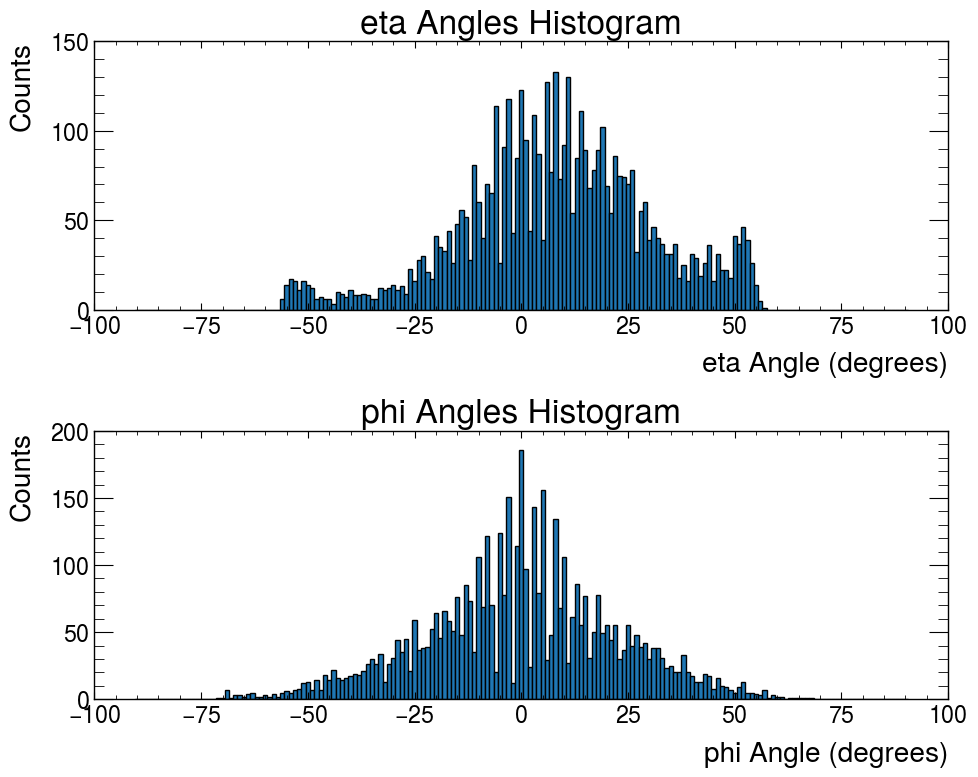

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
event = []

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'Processing event : {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])

                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ(cross_chamber_3_RPC_events, max_length=6, exact_length=False)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')


plt.tight_layout()
plt.show()

processing event: 200
Number of events in filter = 167
processing event: 400
Number of events in filter = 172
processing event: 600
Number of events in filter = 167
processing event: 800
Number of events in filter = 175
processing event: 1000
Number of events in filter = 155
processing event: 1200
Number of events in filter = 170
processing event: 1400
Number of events in filter = 173
processing event: 1600
Number of events in filter = 168
processing event: 1800
Number of events in filter = 169
processing event: 2000
Number of events in filter = 168
processing event: 2200
Number of events in filter = 170
processing event: 2400
Number of events in filter = 177
processing event: 2600
Number of events in filter = 172
processing event: 2800
Number of events in filter = 167
processing event: 3000
Number of events in filter = 167
processing event: 3200
Number of events in filter = 166
processing event: 3400
Number of events in filter = 170
processing event: 3600
Number of events in filter = 

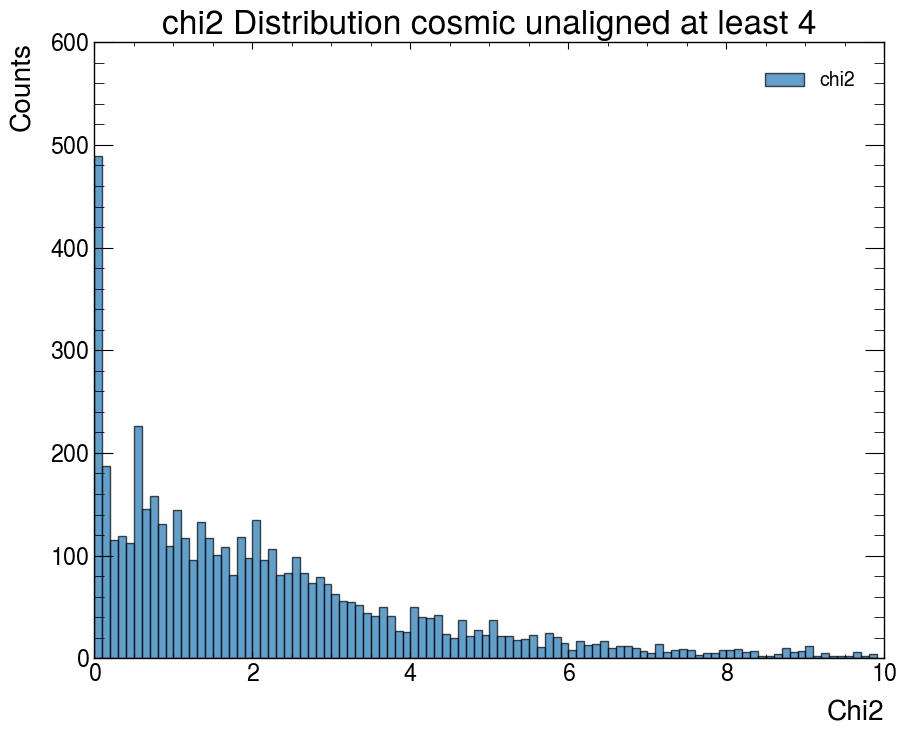

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
event = []

bin_size = 0.1
bin_edges = np.arange(0, 10, bin_size)
num_bins = len(bin_edges) - 1

chi2 = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,4)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,5)
                Chi2_values = []
                for ind,event in enumerate(cross_chamber_3_RPC_events):
                    y = reconstruct_timed_Chi2(event,10, max_length=6, exact_length=False)
                    if y:
                        Chi2_values.append(y[4])
                chi2 += np.histogram(Chi2_values, bins=bin_edges)[0]

print(f"Total chi2 entries: {np.sum(chi2)}")

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(bin_edges[:-1], chi2, width=bin_size, edgecolor='black', align='edge', alpha=0.7, label='chi2')

ax.set_title('chi2 Distribution cosmic unaligned at least 4')
ax.set_xlabel('Chi2')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

Sanity Check Section

Processing event : 200
Number of events in filter = 167
Processing event : 400
Number of events in filter = 172
Processing event : 600
Number of events in filter = 167
Processing event : 800
Number of events in filter = 175
Processing event : 1000
Number of events in filter = 155


C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1242431846.py:340: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1242431846.py:345: RuntimeWarning:

invalid value encountered in scalar multiply

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1242431846.py:340: RuntimeWarning:

invalid value encountered in scalar divide



Processing event : 1200
Number of events in filter = 170
Processing event : 1400
Number of events in filter = 173
Processing event : 1600
Number of events in filter = 168
Processing event : 1800
Number of events in filter = 169
Processing event : 2000
Number of events in filter = 168
Processing event : 2200
Number of events in filter = 170
Processing event : 2400
Number of events in filter = 177
Processing event : 2600
Number of events in filter = 172
Processing event : 2800
Number of events in filter = 167
Processing event : 3000
Number of events in filter = 167
Processing event : 3200
Number of events in filter = 166
Processing event : 3400
Number of events in filter = 170
Processing event : 3600
Number of events in filter = 180
Processing event : 3800
Number of events in filter = 159
Processing event : 4000
Number of events in filter = 177
Processing event : 4200
Number of events in filter = 173
Processing event : 4400
Number of events in filter = 176
Processing event : 4600
Number 

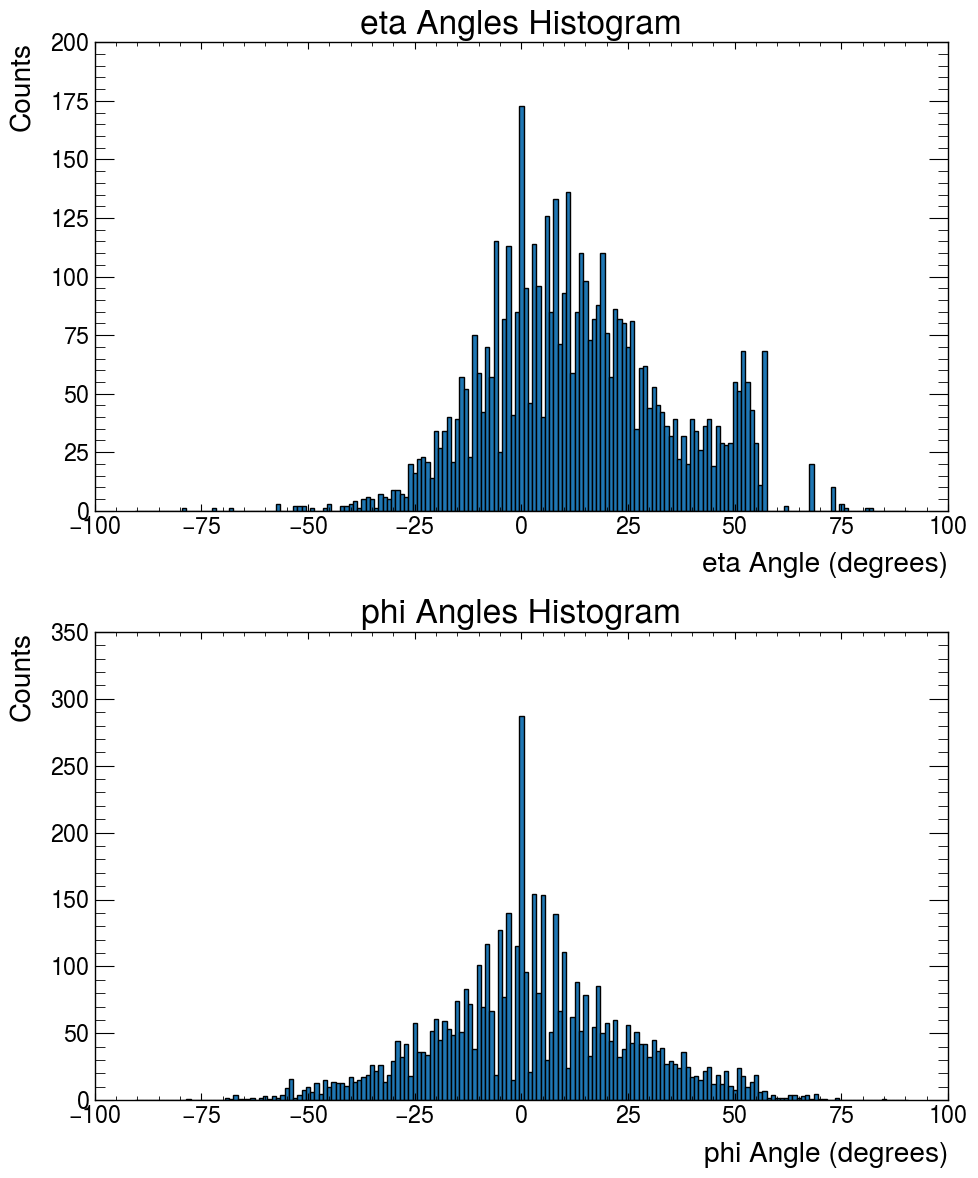

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'Processing event : {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=6, exact_length=False)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')

plt.tight_layout()
plt.show()

processing event: 200
Number of events in filter = 167
processing event: 400
Number of events in filter = 172
processing event: 600
Number of events in filter = 167
processing event: 800
Number of events in filter = 175
processing event: 1000
Number of events in filter = 155
processing event: 1200
Number of events in filter = 170
processing event: 1400
Number of events in filter = 173
processing event: 1600
Number of events in filter = 168
processing event: 1800
Number of events in filter = 169
processing event: 2000
Number of events in filter = 168
processing event: 2200
Number of events in filter = 170
processing event: 2400
Number of events in filter = 177
processing event: 2600
Number of events in filter = 172
processing event: 2800
Number of events in filter = 167
processing event: 3000
Number of events in filter = 167
processing event: 3200
Number of events in filter = 166
processing event: 3400
Number of events in filter = 170
processing event: 3600
Number of events in filter = 

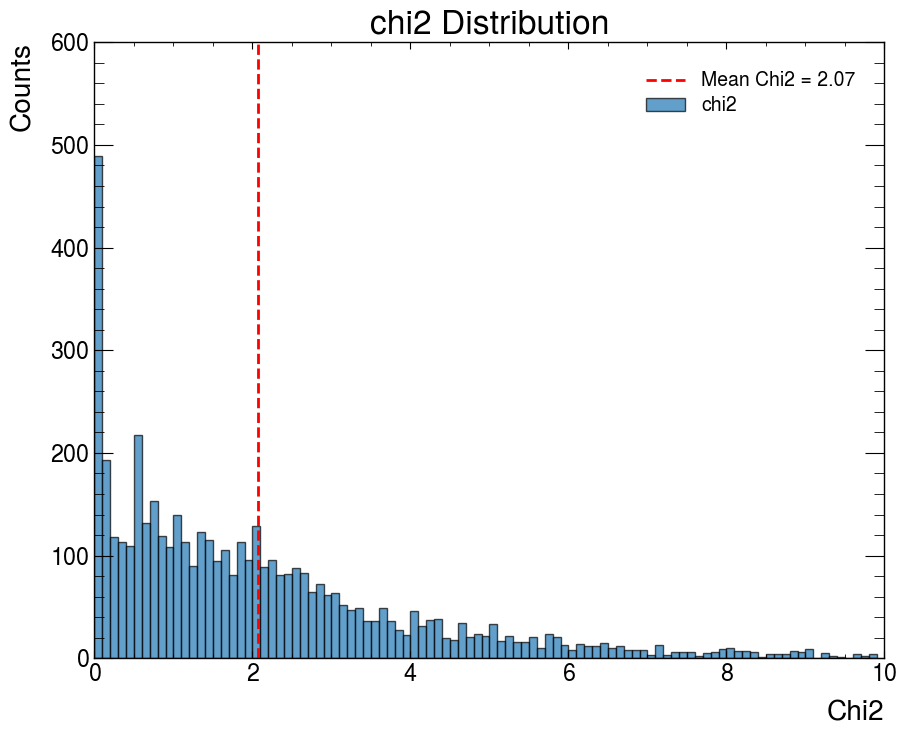

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
event = []

bin_size = 0.1
bin_edges = np.arange(0, 10, bin_size)
num_bins = len(bin_edges) - 1

chi2 = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                Chi2_values = []
                for ind,event in enumerate(cross_chamber_3_RPC_events):
                    y = reconstruct_timed_Chi2(event,3, max_length=6, exact_length=False)
                    if y:
                        Chi2_values.append(y[4])
                        # if processedEvents < 200:
                        #     print(y[-1])
                chi2 += np.histogram(Chi2_values, bins=bin_edges)[0]

print(f"Total chi2 entries: {np.sum(chi2)}")

fig, ax = plt.subplots(figsize=(10, 8))
bin_midpoints = bin_edges[:-1] + bin_size / 2
mean_chi2 = np.average(bin_midpoints, weights=chi2)

ax.bar(bin_edges[:-1], chi2, width=bin_size, edgecolor='black', align='edge', alpha=0.7, label='chi2')
ax.axvline(mean_chi2, color='red', linestyle='dashed', linewidth=2, label=f'Mean Chi2 = {mean_chi2:.2f}')

ax.set_title('chi2 Distribution')
ax.set_xlabel('Chi2')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

Exactly Bottom 4 analysis

Processing event : 200
Processing event : 400
Processing event : 600
Processing event : 800
Processing event : 1000
Processing event : 1200
Processing event : 1400
Processing event : 1600
Processing event : 1800
Processing event : 2000
Processing event : 2200
Processing event : 2400
Processing event : 2600
Processing event : 2800
Processing event : 3000
Processing event : 3200
Processing event : 3400
Processing event : 3600
Processing event : 3800
Processing event : 4000
Processing event : 4200
Processing event : 4400
Processing event : 4600
Processing event : 4800
Processing event : 5000
Processing event : 5200
Processing event : 5400
Processing event : 5600
Processing event : 5800
Processing event : 6000
Processing event : 6200
Processing event : 6400
Processing event : 6600
Processing event : 6800
Processing event : 7000
Processing event : 7200
Processing event : 7400
Processing event : 7600
Processing event : 7800
Processing event : 8000
Processing event : 8200
Bad Block Read
Total

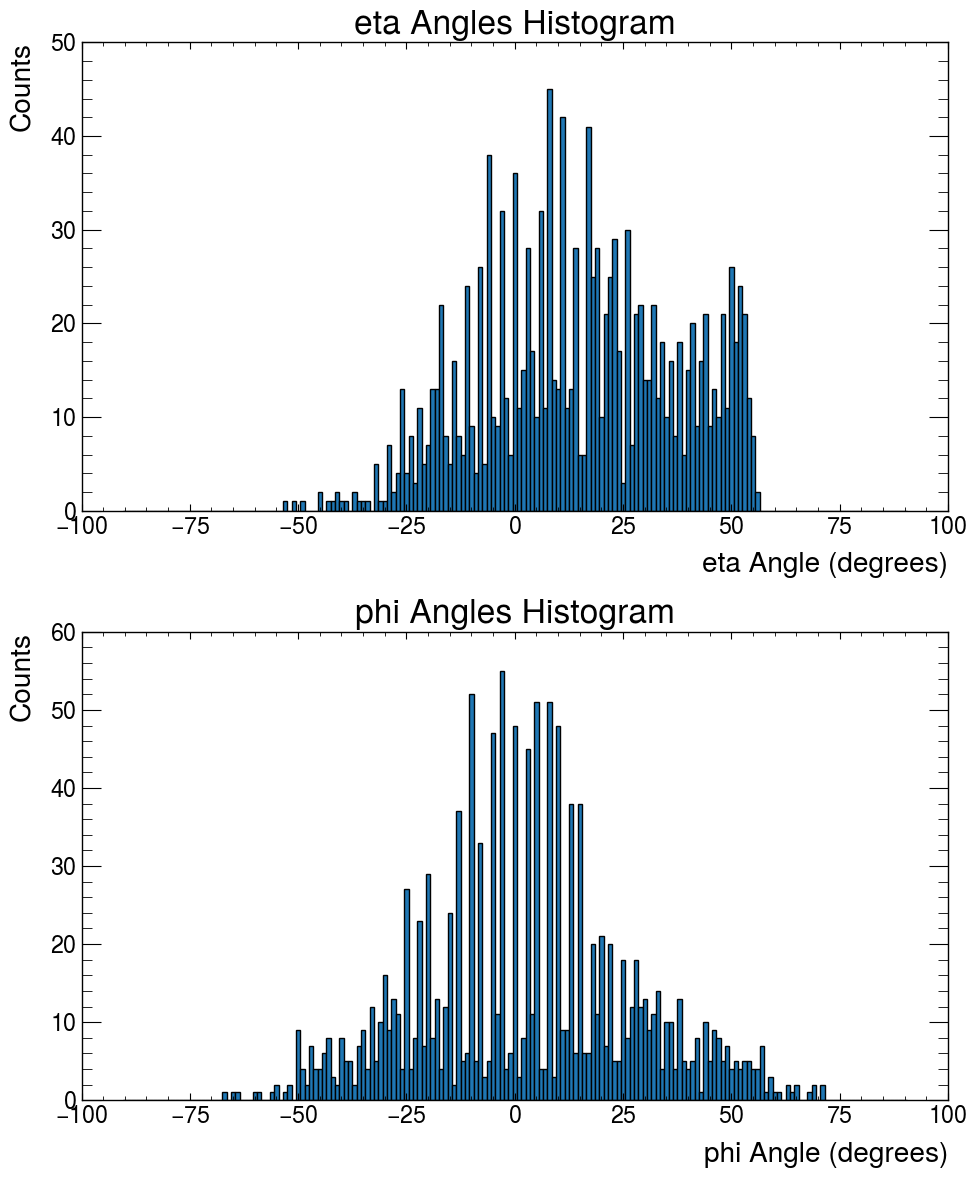

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'Processing event : {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                # cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')

plt.tight_layout()
plt.show()

processing event: 200
processing event: 400
processing event: 600
processing event: 800
processing event: 1000
processing event: 1200
processing event: 1400
processing event: 1600
processing event: 1800
processing event: 2000
processing event: 2200
processing event: 2400
processing event: 2600
processing event: 2800
processing event: 3000
processing event: 3200
processing event: 3400
processing event: 3600
processing event: 3800
processing event: 4000
processing event: 4200
processing event: 4400
processing event: 4600
processing event: 4800
processing event: 5000
processing event: 5200
processing event: 5400
processing event: 5600
processing event: 5800
processing event: 6000
processing event: 6200
processing event: 6400
processing event: 6600
processing event: 6800
processing event: 7000
processing event: 7200
processing event: 7400
processing event: 7600
processing event: 7800
processing event: 8000
processing event: 8200
Bad Block Read
Total chi2 entries: 1364.0


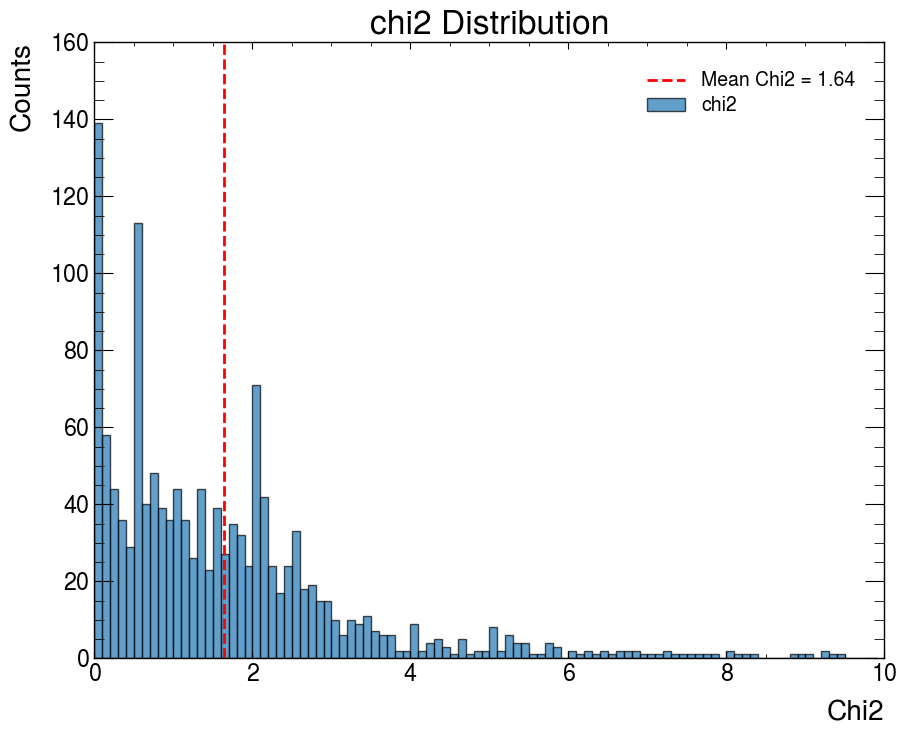

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
event = []

bin_size = 0.1
bin_edges = np.arange(0, 10, bin_size)
num_bins = len(bin_edges) - 1

chi2 = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                # cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                Chi2_values = []
                for ind,event in enumerate(cross_chamber_3_RPC_events):
                    y = reconstruct_timed_Chi2(event,3, max_length=4, exact_length=True)
                    if y:
                        Chi2_values.append(y[4])
                        # if processedEvents < 200:
                        #     print(y[-1])
                chi2 += np.histogram(Chi2_values, bins=bin_edges)[0]

print(f"Total chi2 entries: {np.sum(chi2)}")

fig, ax = plt.subplots(figsize=(10, 8))
bin_midpoints = bin_edges[:-1] + bin_size / 2
mean_chi2 = np.average(bin_midpoints, weights=chi2)

ax.bar(bin_edges[:-1], chi2, width=bin_size, edgecolor='black', align='edge', alpha=0.7, label='chi2')
ax.axvline(mean_chi2, color='red', linestyle='dashed', linewidth=2, label=f'Mean Chi2 = {mean_chi2:.2f}')

ax.set_title('chi2 Distribution')
ax.set_xlabel('Chi2')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

Processing event : 200
Processing event : 400
Processing event : 600
Processing event : 800
Processing event : 1000
Processing event : 1200
Processing event : 1400
Processing event : 1600
Processing event : 1800
Processing event : 2000
Processing event : 2200
Processing event : 2400
Processing event : 2600
Processing event : 2800
Processing event : 3000
Processing event : 3200
Processing event : 3400
Processing event : 3600
Processing event : 3800
Processing event : 4000
Processing event : 4200
Processing event : 4400
Processing event : 4600
Processing event : 4800
Processing event : 5000
Processing event : 5200
Processing event : 5400
Processing event : 5600
Processing event : 5800
Processing event : 6000
Processing event : 6200
Processing event : 6400
Processing event : 6600
Processing event : 6800
Processing event : 7000
Processing event : 7200
Processing event : 7400
Processing event : 7600
Processing event : 7800
Processing event : 8000
Processing event : 8200
Processing event : 8

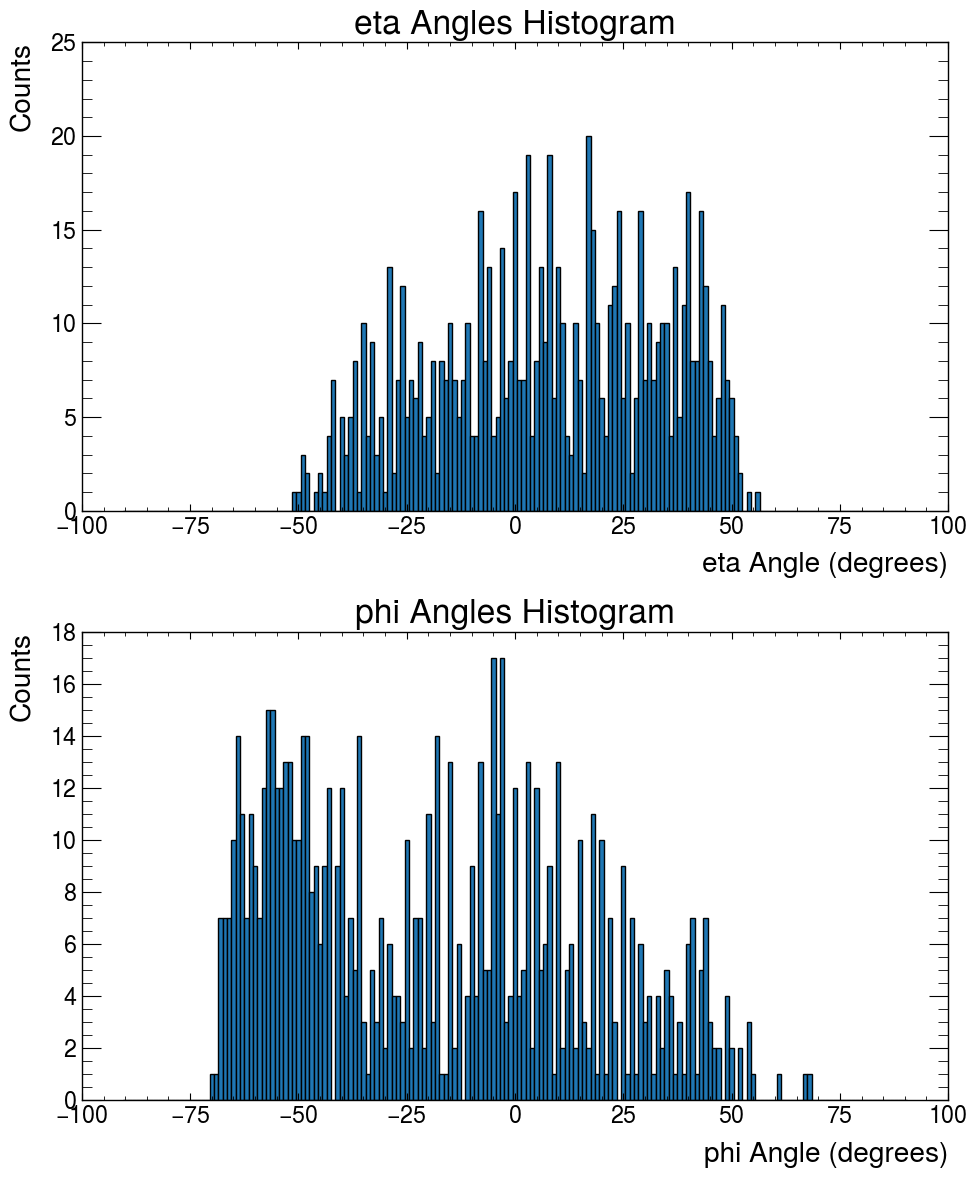

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'Processing event : {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                # cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')

plt.tight_layout()
plt.show()

processing event: 200
processing event: 400
processing event: 600
processing event: 800
processing event: 1000
processing event: 1200
processing event: 1400
processing event: 1600
processing event: 1800
processing event: 2000
processing event: 2200
processing event: 2400
processing event: 2600
processing event: 2800
processing event: 3000
processing event: 3200
processing event: 3400
processing event: 3600
processing event: 3800
processing event: 4000
processing event: 4200
processing event: 4400
processing event: 4600
processing event: 4800
processing event: 5000
processing event: 5200
processing event: 5400
processing event: 5600
processing event: 5800
processing event: 6000
processing event: 6200
processing event: 6400
processing event: 6600
processing event: 6800
processing event: 7000
processing event: 7200
processing event: 7400
processing event: 7600
processing event: 7800
processing event: 8000
processing event: 8200
processing event: 8400
processing event: 8600
processing even

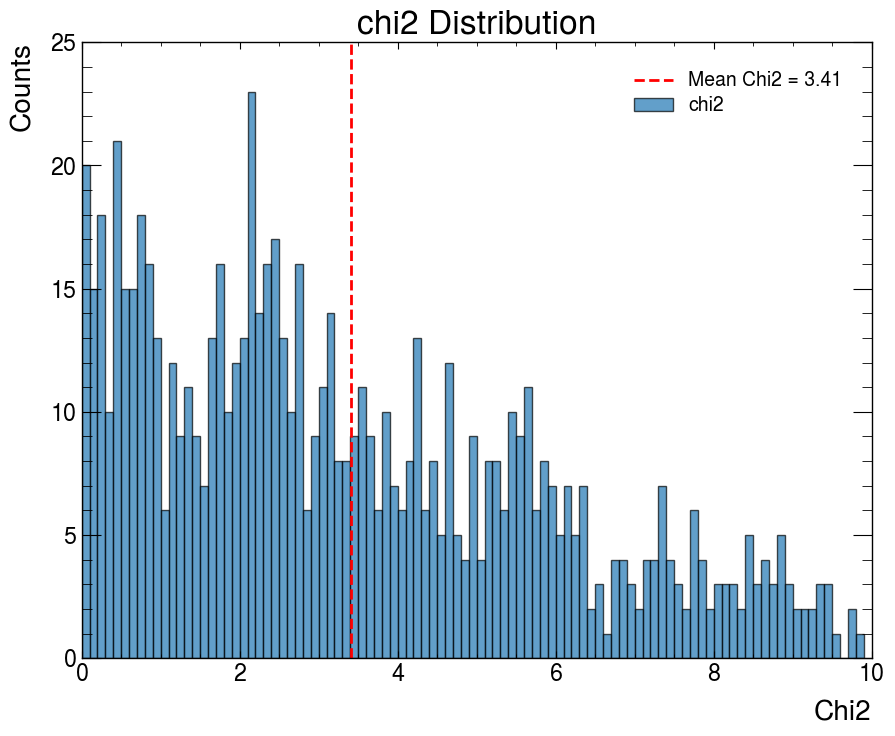

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
event = []

bin_size = 0.1
bin_edges = np.arange(0, 10, bin_size)
num_bins = len(bin_edges) - 1

chi2 = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                # cross_chamber_3_RPC_events = filter_events(hit_cluster,2,3)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                Chi2_values = []
                for ind,event in enumerate(cross_chamber_3_RPC_events):
                    y = reconstruct_timed_Chi2(event,3, max_length=4, exact_length=True)
                    if y:
                        Chi2_values.append(y[4])
                        # if processedEvents < 200:
                        #     print(y[-1])
                chi2 += np.histogram(Chi2_values, bins=bin_edges)[0]

print(f"Total chi2 entries: {np.sum(chi2)}")

fig, ax = plt.subplots(figsize=(10, 8))
bin_midpoints = bin_edges[:-1] + bin_size / 2
mean_chi2 = np.average(bin_midpoints, weights=chi2)

ax.bar(bin_edges[:-1], chi2, width=bin_size, edgecolor='black', align='edge', alpha=0.7, label='chi2')
ax.axvline(mean_chi2, color='red', linestyle='dashed', linewidth=2, label=f'Mean Chi2 = {mean_chi2:.2f}')

ax.set_title('chi2 Distribution')
ax.set_xlabel('Chi2')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

Now if we apply a TDC alignment for both TDC0 TDC1 and partially TDC2

For now lets separate the two to make things easier to do

In [ ]:
importlib.reload(rawFileReader)
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
aligned = True
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                # aligned = doRealign(fReader,events[-200:])
                if lastWasBad and not aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False

In [ ]:
offsetTest = []
for offSet in range(6):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3
4
5


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_5280\3146992200.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


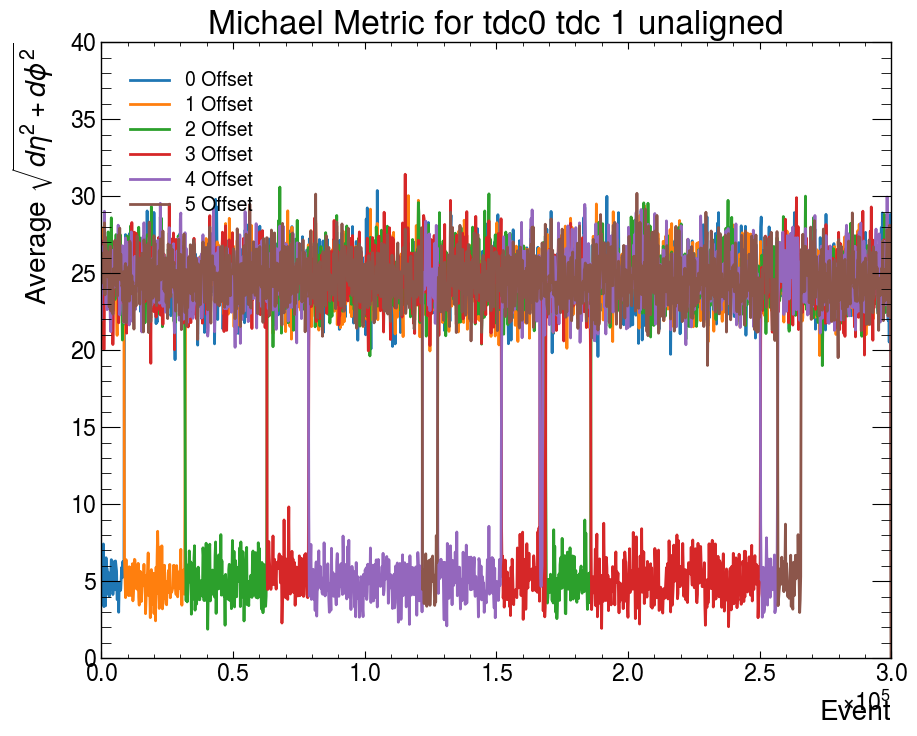

In [ ]:
binsx = [x*200 for x in range(3000)]
noffs = 6
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1 unaligned')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

Now for TDC1 and 2

In [ ]:
offsetTest = []
Temp_event_num = 0
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                elif thisHit.eta == False and thisHit.channel > 31:
                    phiHits[rpc].append(thisHit)        
            # etOff = testAlign(etaHits[1],etaHits[2])
            
            phOff = testAlign(phiHits[2],phiHits[1])
            Metric =phOff*phOff
            # print(Metric)
            if phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_5280\3796555203.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\phi^2}$')


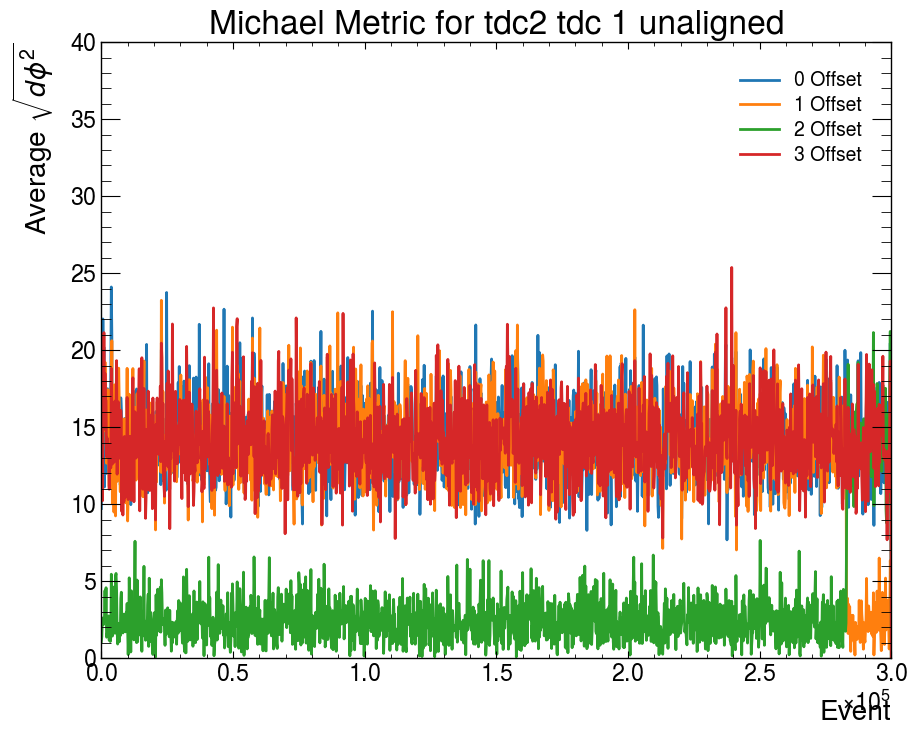

In [ ]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 1 unaligned')
ax.set_ylabel('Average $\sqrt{d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [ ]:
offsetTest = []
Temp_event_num = 0
for offSet in range(8):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                elif thisHit.eta == False and thisHit.channel > 31:
                    phiHits[rpc].append(thisHit)        
            # etOff = testAlign(etaHits[1],etaHits[2])
            
            phOff = testAlign(phiHits[2],phiHits[0])
            Metric =phOff*phOff
            # print(Metric)
            if phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3
4
5
6
7


<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_5280\1860096920.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\phi^2}$')


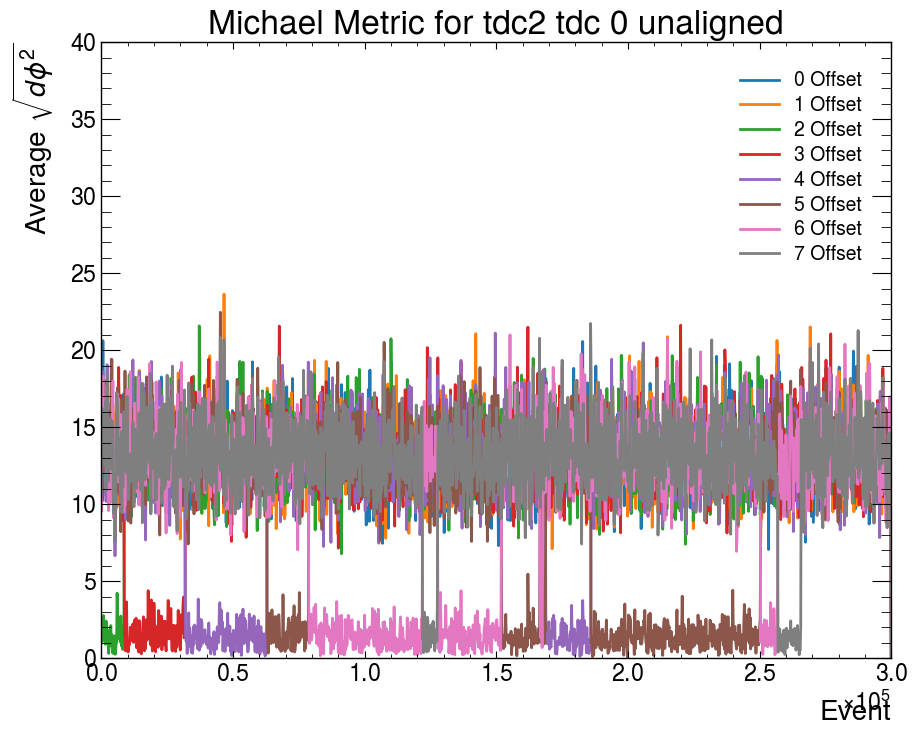

In [ ]:
binsx = [x*200 for x in range(3000)]
noffs = 8
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 0 unaligned')
ax.set_ylabel('Average $\sqrt{d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [70]:
importlib.reload(rawFileReader)
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
# aligned = True
alignevt = [[[], [], []], [[], [], []], [[], [], []]]
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            if processedEvents%200==0 and processedEvents>0:
                aligned10, update10 = doRealign(fReader,events[-200:])
                if update10 != -1:
                    if update10 == 1:   
                        alignevt[1][0].append(processedEvents)
                    else:
                        alignevt[0][1].append(processedEvents)
                aligned21, update21 = doRealign(fReader, events[-200:], -1, -1, 2, 1, 2, 1)
                if update21 != -1:
                    if update10 == 2:   
                        alignevt[2][1].append(processedEvents)
                    else:
                        alignevt[1][2].append(processedEvents)
                aligned20, update20 = doRealign(fReader, events[-200:], -1, -1, 2, 0, 2, 0)
                if update20 != -1:
                    if update10 == 2:   
                        alignevt[2][0].append(processedEvents)
                    else:
                        alignevt[0][2].append(processedEvents)
                    
                totally_aligned = aligned10 and aligned21 and aligned20
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False                  

Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by -2 idx is 400 updated TDC 1
Found a new alignment, offsetting by -2 idx is 400 updated TDC 0
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 2
Two bad aligns in a row, processedEvents is 42200
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 122200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 122200 updated TDC 2
Found a new alignment, offsettin

In [71]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3


<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\2880781655.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


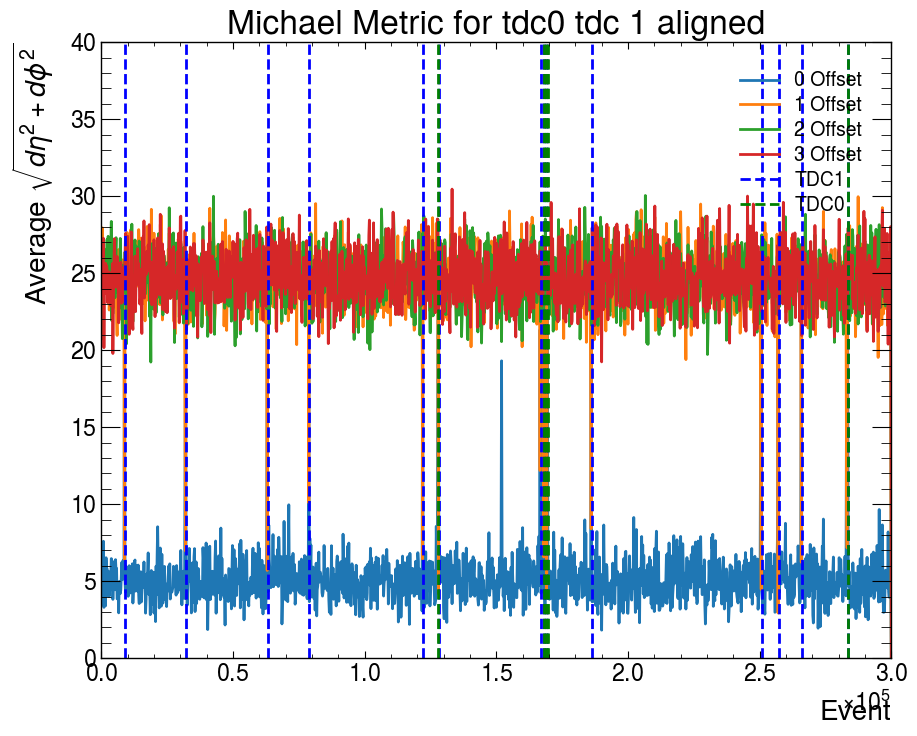

In [72]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[1][0]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='b', linestyle='--', label='TDC1')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='b', linestyle='--')
for x in alignevt[0][1]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='g', linestyle='--', label='TDC0')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='g', linestyle='--')
ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1 aligned')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [73]:
offsetTest = []
Temp_event_num = 0
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                elif thisHit.eta == False and thisHit.channel > 31:
                    phiHits[rpc].append(thisHit)        
            # etOff = testAlign(etaHits[1],etaHits[2])
            
            phOff = testAlign(phiHits[2],phiHits[1])
            Metric =phOff*phOff
            # print(Metric)
            if phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   


0
1
2
3


<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\200323551.py:43: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\phi^2}$')


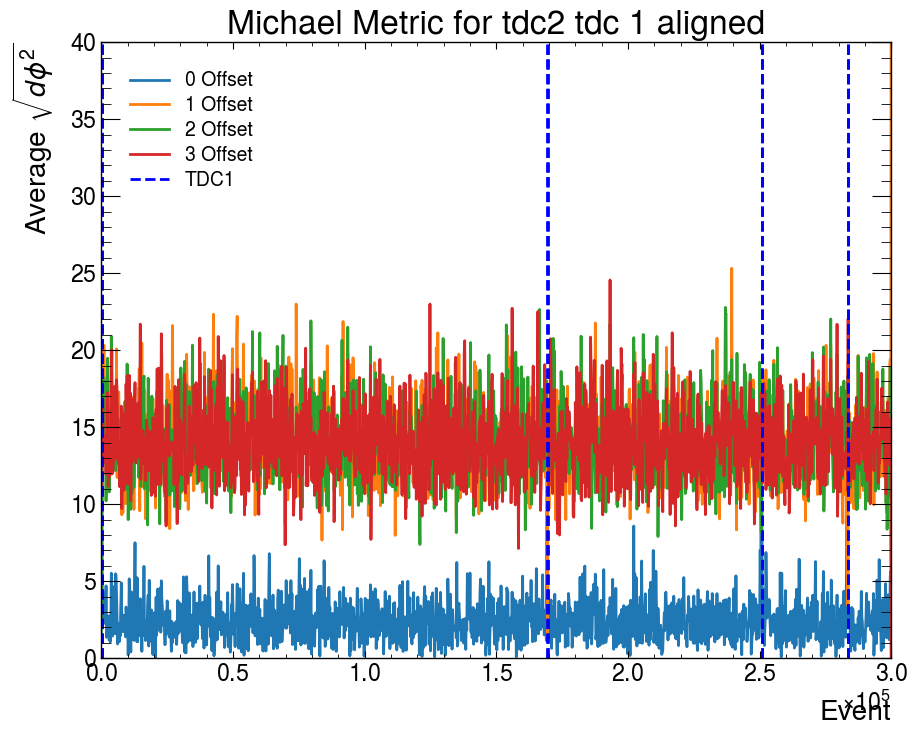

In [74]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')
    
plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[1][2]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='b', linestyle='--', label='TDC1')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='b', linestyle='--')
for x in alignevt[2][1]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='r', linestyle='--', label='TDC2')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='r', linestyle='--')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 1 aligned')
ax.set_ylabel('Average $\sqrt{d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [75]:
offsetTest = []
Temp_event_num = 0
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                else:
                    phiHits[rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, Temp_event_num)
                if thisHit.eta:
                    etaHits[rpc].append(thisHit)
                elif thisHit.eta == False and thisHit.channel > 31:
                    phiHits[rpc].append(thisHit)        
            # etOff = testAlign(etaHits[1],etaHits[2])
            
            phOff = testAlign(phiHits[2],phiHits[0])
            Metric =phOff*phOff
            # print(Metric)
            if phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   

0
1
2
3


<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\3961275217.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\phi^2}$')


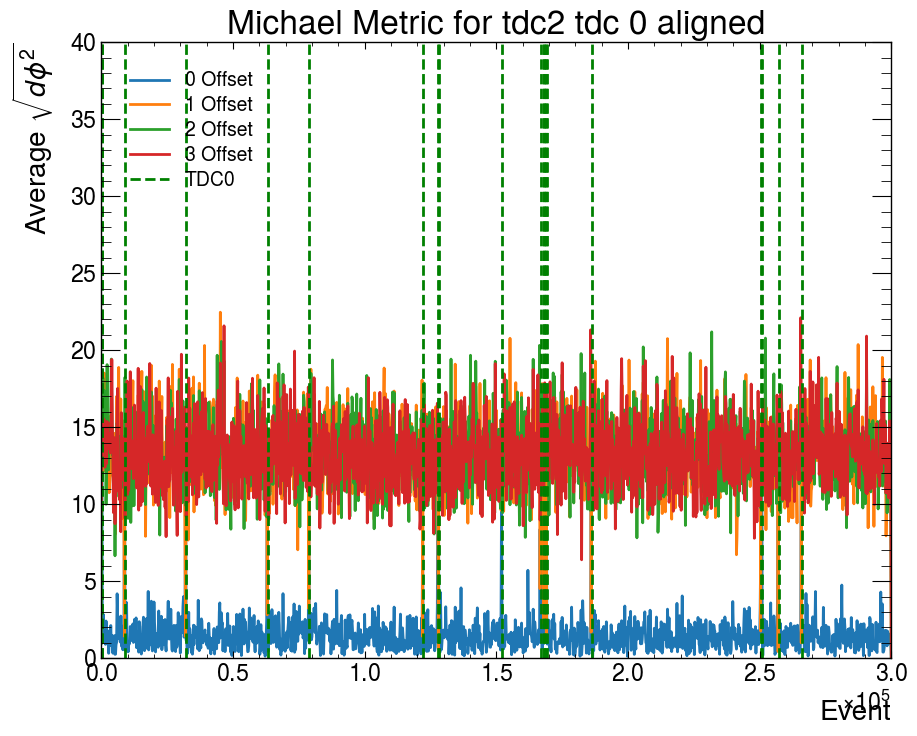

In [76]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')
plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[2][0]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='r', linestyle='--', label='TDC2')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='r', linestyle='--')
for x in alignevt[0][2]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='g', linestyle='--', label='TDC0')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='g', linestyle='--')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 0 aligned')
ax.set_ylabel('Average $\sqrt{d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

test zone

In [79]:
importlib.reload(rawFileReader)
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
alignevt = [[[], [], []], [[], [], []], [[], [], []]]

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)
            processedEvents += 1
            if processedEvents % 200 == 0 and processedEvents > 0:
                aligned10, update10 = doRealign(fReader, events[-200:])
                if update10 != -1:
                    if update10 == 1:   
                        alignevt[1][0].append(processedEvents)
                    else:
                        alignevt[0][1].append(processedEvents)
                aligned21, update21 = doRealign(fReader, events[-200:], 3, 2, 3, 2, 2, 1)
                if update21 != -1:
                    if update10 == 2:   
                        alignevt[2][1].append(processedEvents)
                    else:
                        alignevt[1][2].append(processedEvents)
                aligned20, update20 = doRealign(fReader, events[-200:], 3, 0, 3, 0, 2, 0)
                if update20 != -1:
                    if update10 == 2:   
                        alignevt[2][0].append(processedEvents)
                    else:
                        alignevt[0][2].append(processedEvents)

                totally_aligned = aligned10 and aligned21 and aligned20
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is", processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False


Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by -2 idx is 400 updated TDC 1
Found a new alignment, offsetting by -2 idx is 400 updated TDC 0
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 2
Two bad aligns in a row, processedEvents is 42200
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 122200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 122200 updated TDC 2
Found a new alignment, offsettin

KeyboardInterrupt: 

<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\2231580496.py:79: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


0
1
2
3


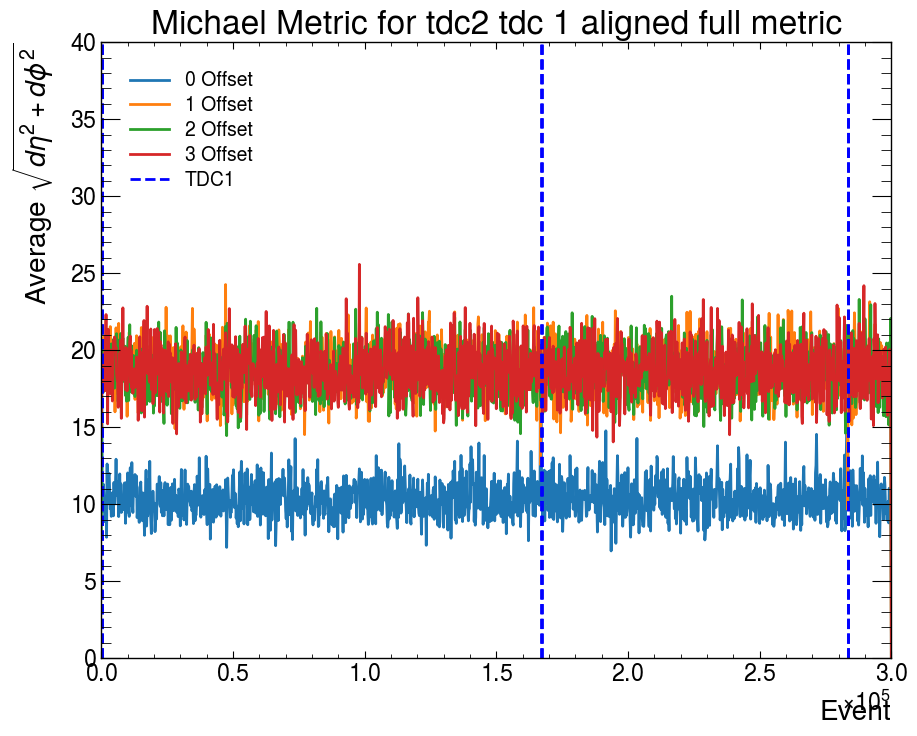

In [64]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[3],etaHits[2])
            phOff = testAlign(phiHits[3],phiHits[2])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')
    
plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[2][1]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='r', linestyle='--', label='TDC2')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='r', linestyle='--')
for x in alignevt[1][2]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='b', linestyle='--', label='TDC1')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='b', linestyle='--')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 1 aligned full metric')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\4139542181.py:79: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


0
1
2
3


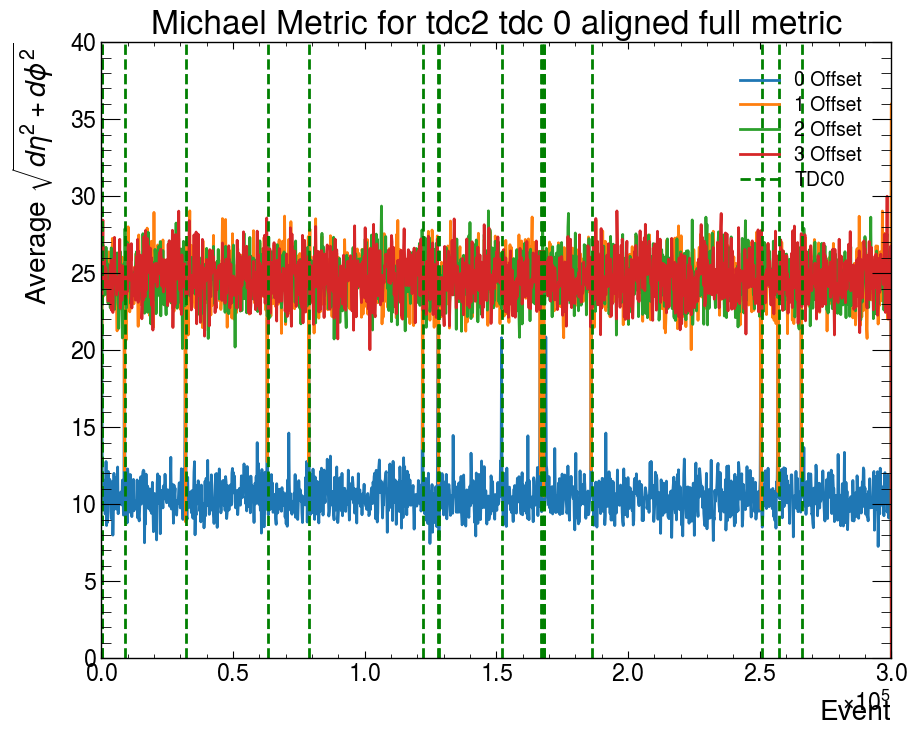

In [67]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[3],etaHits[0])
            phOff = testAlign(phiHits[3],phiHits[0])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[2][0]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='r', linestyle='--', label='TDC2')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='r', linestyle='--')
for x in alignevt[0][2]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='g', linestyle='--', label='TDC0')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='g', linestyle='--')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 0 aligned full metric')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:80: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\32132369.py:80: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


0
1
2
3


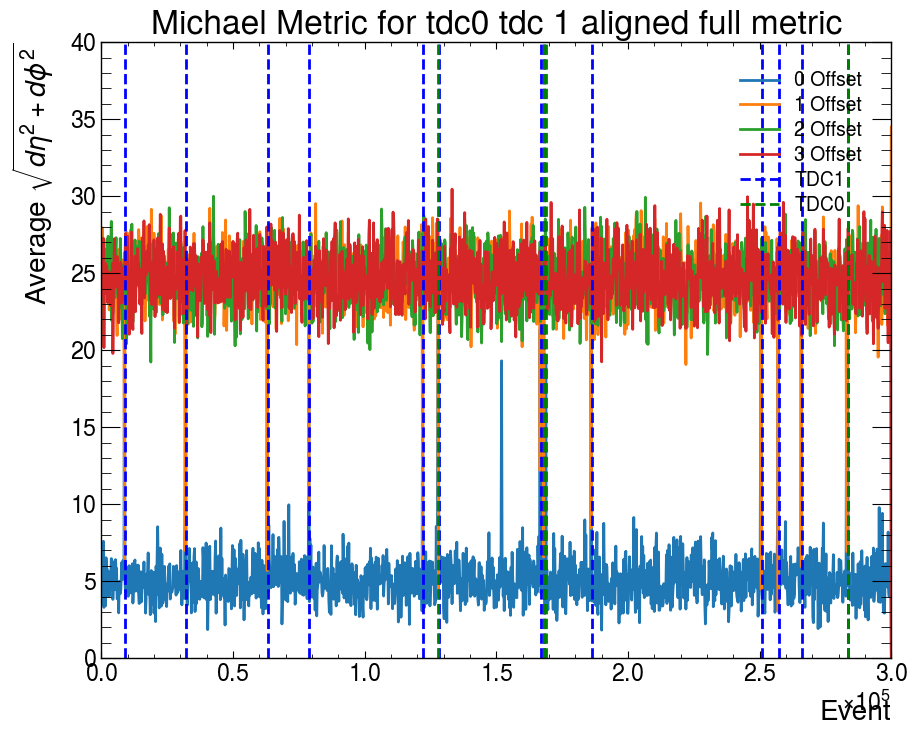

In [78]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[0].words:
                rpc, thisHit = tdcChanToRPCHit(word,0, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[1],etaHits[2])
            phOff = testAlign(phiHits[0],phiHits[1])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')
    
plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[1][0]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='b', linestyle='--', label='TDC1')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='b', linestyle='--')
for x in alignevt[0][1]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='g', linestyle='--', label='TDC0')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='g', linestyle='--')


ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1 aligned full metric')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by 2 idx is 200 updated TDC 2
Found a new alignment, offsetting by -2 idx is 400 updated TDC 1
Found a new alignment, offsetting by -2 idx is 400 updated TDC 0
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 2
Two bad aligns in a row, processedEvents is 42200
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 2


C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\2449406745.py:340: RuntimeWarning: divide by zero encountered in scalar divide
  t = (z-z_0)/d[2]
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\2449406745.py:344: RuntimeWarning: invalid value encountered in scalar multiply
  x_traj = centroid[0] + t*d[0]


Found a new alignment, offsetting by 1 idx is 122200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 122200 updated TDC 2
Found a new alignment, offsetting by -1 idx is 128000 updated TDC 0
Found a new alignment, offsetting by -1 idx is 128000 updated TDC 0
Found a new alignment, offsetting by 1 idx is 128200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 128200 updated TDC 2
Two bad aligns in a row, processedEvents is 141200
Found a new alignment, offsetting by -1 idx is 152200 updated TDC 0
Found a new alignment, offsetting by 1 idx is 166800 updated TDC 1
Found a new alignment, offsetting by 1 idx is 167000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 167000 updated TDC 2
Found a new alignment, offsetting by -1 idx is 167200 updated TDC 1
Found a new alignment, offsetting by -1 idx is 167200 updated TDC 0
Found a new alignment, offsetting by -1 idx is 168000 updated TDC 0
Found a new alignment, offsetting by -1 idx is 168000 updated TDC 0
Foun

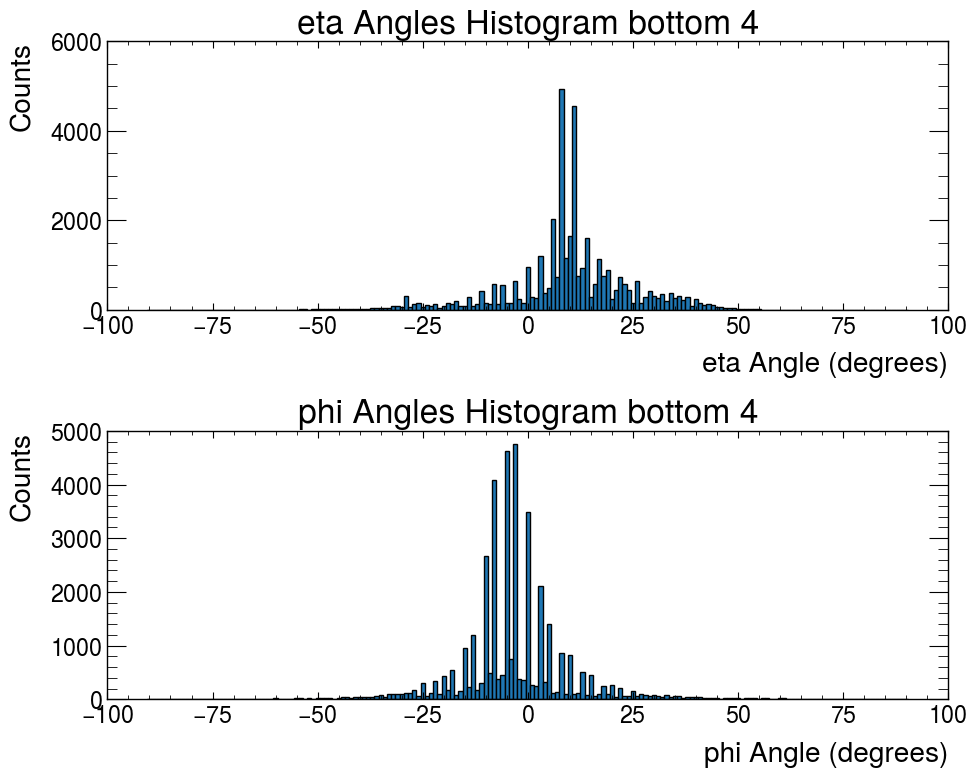

In [81]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
aligned = True
lastWasBad = False

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                aligned1, update10 = doRealign(fReader,events[-interval:])
                aligned2, update21 = doRealign(fReader, events[-interval:], 3, 2, 3, 2, 2, 1)
                aligned3, update20 = doRealign(fReader, events[-interval:], 3, 0, 3, 0, 2, 0)
                totally_aligned = aligned1==True and aligned2==True and aligned3==True
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])

                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram bottom 4')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram bottom 4')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')


plt.tight_layout()
plt.show()

Number of events in filter = 93
Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
Number of events in filter = 91
Found a new alignment, offsetting by -2 idx is 600 updated TDC 1
Found a new alignment, offsetting by -2 idx is 600 updated TDC 0
Number of events in filter = 103
Number of events in filter = 97
Number of events in filter = 93
Number of events in filter = 93
Number of events in filter = 91
Number of events in filter = 87
Number of events in filter = 90
Number of events in filter = 88
Number of events in filter = 98
Number of events in filter = 88
Number of events in filter = 94
Number of events in filter = 84
Number of events in filter = 102
Number of events in filter = 88
Number of events in filter = 106
Number of events in filter = 97
Number of events in filter = 93
Number of events in filter = 98
Number of events in filter = 82


C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:340: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:340: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:345: RuntimeWarning:

invalid value encountered in scalar multiply



Number of events in filter = 86
Number of events in filter = 83
Number of events in filter = 103
Number of events in filter = 98
Number of events in filter = 92
Number of events in filter = 92
Number of events in filter = 91
Number of events in filter = 103
Number of events in filter = 103
Number of events in filter = 87
Number of events in filter = 90
Number of events in filter = 72
Number of events in filter = 91
Number of events in filter = 116
Number of events in filter = 85
Number of events in filter = 101
Number of events in filter = 83
Number of events in filter = 97
Number of events in filter = 103


C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:344: RuntimeWarning:

invalid value encountered in scalar multiply



Number of events in filter = 78
Number of events in filter = 94
Number of events in filter = 79
Number of events in filter = 92
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 2
Number of events in filter = 95
Number of events in filter = 90
Number of events in filter = 91
Number of events in filter = 94
Number of events in filter = 89
Number of events in filter = 93
Number of events in filter = 92
Number of events in filter = 85
Number of events in filter = 92
Number of events in filter = 82
Number of events in filter = 112
Number of events in filter = 87
Number of events in filter = 83
Number of events in filter = 99
Number of events in filter = 90
Number of events in filter = 94
Number of events in filter = 100
Number of events in filter = 85
Number of events in filter = 87
Number of events in filter = 87
Number of events in filter = 93
Number of events in filter = 88
Number of events in filter = 104
Num

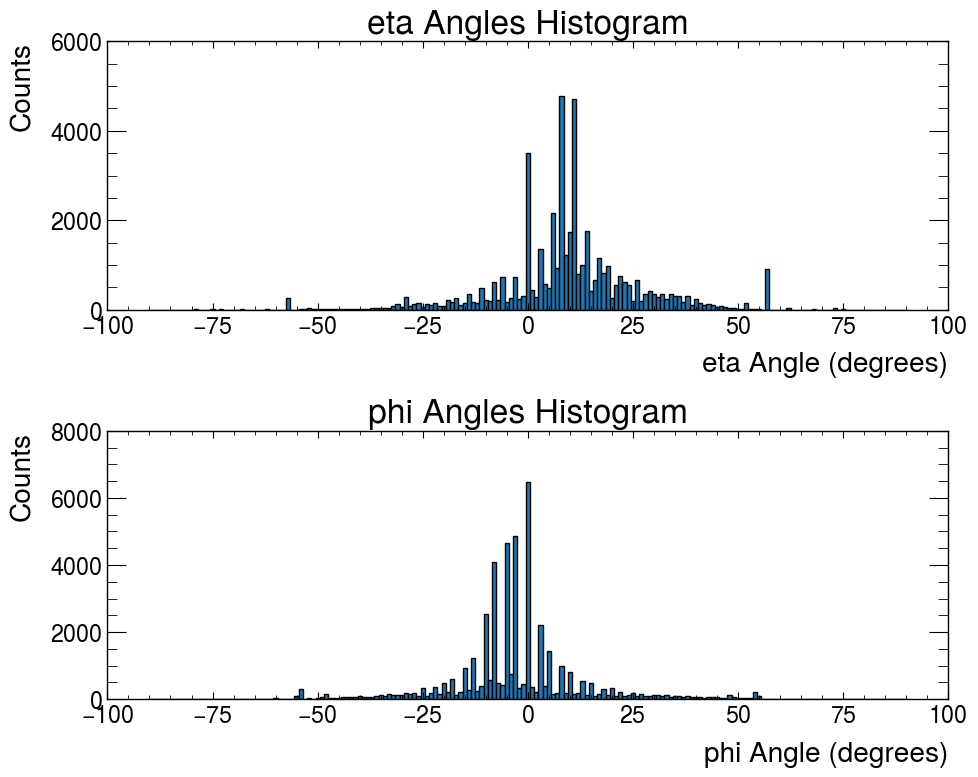

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
aligned = True
lastWasBad = False

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                aligned1 = doRealign(fReader,events[-interval:])
                aligned2 = doRealign(fReader, events[-interval:], -1, -1, 2, 1, 2, 1)
                aligned3 = doRealign(fReader, events[-interval:], -1, -1, 2, 0, 2, 0)
                totally_aligned = aligned1 and aligned2 and aligned
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events(hit_cluster,2,4)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,4)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,5)

                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=6, exact_length=False)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')


plt.tight_layout()
plt.show()

Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
Found a new alignment, offsetting by -2 idx is 600 updated TDC 1
Found a new alignment, offsetting by -2 idx is 600 updated TDC 0
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 9000 updated TDC 2
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 32200 updated TDC 2
Two bad aligns in a row, processedEvents is 42200
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 63200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 79000 updated TDC 1
Found a new alignment, offsetting by 1 idx is 79200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 79200 updated TDC 2
Found a new alignment, offsetting by -1 idx is 79400 updated TDC 1
Found a new alignment, offsetting

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:340: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:344: RuntimeWarning:

invalid value encountered in scalar multiply



Found a new alignment, offsetting by 1 idx is 122200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 122400 updated TDC 2
Found a new alignment, offsetting by 1 idx is 122400 updated TDC 2
Found a new alignment, offsetting by -1 idx is 122600 updated TDC 1
Found a new alignment, offsetting by -1 idx is 122600 updated TDC 0
Found a new alignment, offsetting by -1 idx is 128000 updated TDC 0
Found a new alignment, offsetting by -1 idx is 128000 updated TDC 0
Found a new alignment, offsetting by 1 idx is 128200 updated TDC 1
Found a new alignment, offsetting by 1 idx is 128200 updated TDC 2
Found a new alignment, offsetting by -1 idx is 152200 updated TDC 0
Found a new alignment, offsetting by 1 idx is 166800 updated TDC 1
Found a new alignment, offsetting by 1 idx is 167000 updated TDC 2
Found a new alignment, offsetting by -1 idx is 168000 updated TDC 0
Found a new alignment, offsetting by -1 idx is 168000 updated TDC 0
Found a new alignment, offsetting by 1 idx is 168200 up

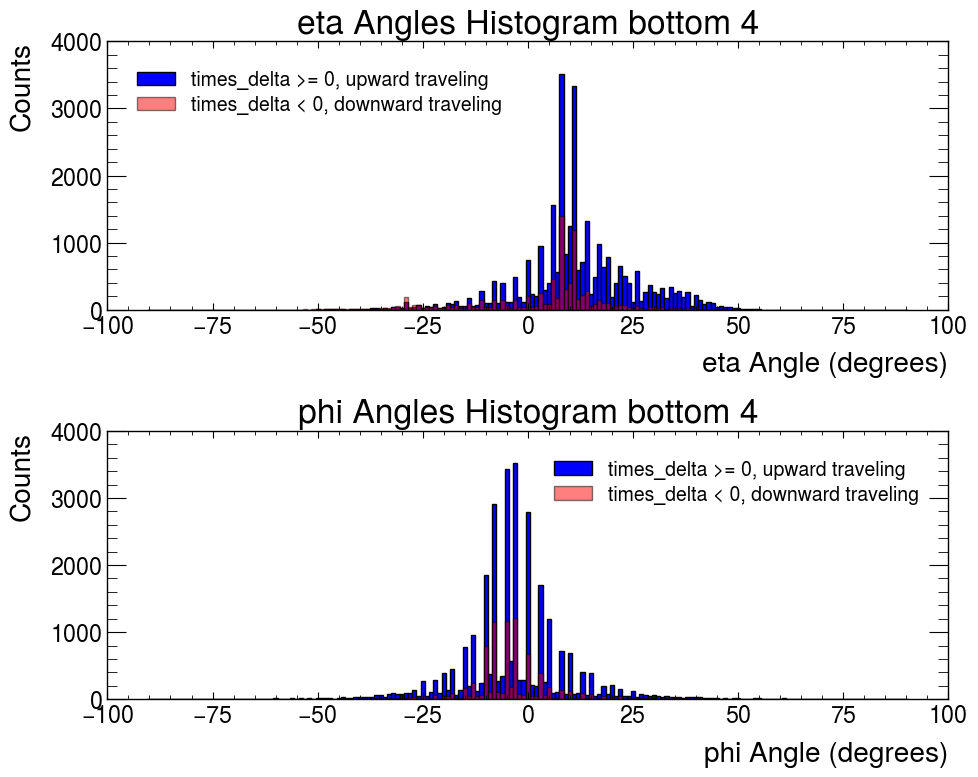

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
aligned = True
lastWasBad = False

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram_pos = np.zeros(num_bins)
eta_histogram_neg = np.zeros(num_bins)
phi_histogram_pos = np.zeros(num_bins)
phi_histogram_neg = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents % interval == 0 and processedEvents > 0:
                aligned1 = doRealign(fReader, events[-interval:])
                aligned2 = doRealign(fReader, events[-interval:], -1, -1, 2, 1, 2, 1)
                aligned3 = doRealign(fReader, events[-interval:], -1, -1, 2, 0, 2, 0)
                totally_aligned = aligned1[0] == True and aligned2[0] == True and aligned3[0] == True
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is", processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits, phiHits, 15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster, 2, 4, [4, 5])

                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                for eta, phi, time in zip(angles_eta_degrees, angles_phi_degrees, times_delta):
                    if time >= 0:
                        eta_histogram_pos += np.histogram([eta], bins=bin_edges)[0]
                        phi_histogram_pos += np.histogram([phi], bins=bin_edges)[0]
                    else:
                        eta_histogram_neg += np.histogram([eta], bins=bin_edges)[0]
                        phi_histogram_neg += np.histogram([phi], bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram_pos) + np.sum(eta_histogram_neg)}")
print(f"Total phi entries: {np.sum(phi_histogram_pos) + np.sum(phi_histogram_neg)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot eta histogram
ax1.bar(bin_edges[:-1], eta_histogram_pos, width=bin_size, edgecolor='black', align='edge', color='blue', label='times_delta >= 0, upward traveling')
ax1.bar(bin_edges[:-1], eta_histogram_neg, width=bin_size, edgecolor='black', align='edge', color='red', alpha=0.5, label='times_delta < 0, downward traveling')
ax1.set_title('eta Angles Histogram bottom 4')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')
ax1.legend()

# Plot phi histogram
ax2.bar(bin_edges[:-1], phi_histogram_pos, width=bin_size, edgecolor='black', align='edge', color='blue', label='times_delta >= 0, upward traveling')
ax2.bar(bin_edges[:-1], phi_histogram_neg, width=bin_size, edgecolor='black', align='edge', color='red', alpha=0.5, label='times_delta < 0, downward traveling')
ax2.set_title('phi Angles Histogram bottom 4')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')
ax2.legend()

plt.tight_layout()
plt.show()

Two bad aligns in a row, processedEvents is 400
Two bad aligns in a row, processedEvents is 600
Two bad aligns in a row, processedEvents is 800
Two bad aligns in a row, processedEvents is 1000
Two bad aligns in a row, processedEvents is 1200
Two bad aligns in a row, processedEvents is 1400
Two bad aligns in a row, processedEvents is 1600
Two bad aligns in a row, processedEvents is 1800
Two bad aligns in a row, processedEvents is 2000
Two bad aligns in a row, processedEvents is 2200
Two bad aligns in a row, processedEvents is 2400
Two bad aligns in a row, processedEvents is 2600
Two bad aligns in a row, processedEvents is 2800
Two bad aligns in a row, processedEvents is 3000
Two bad aligns in a row, processedEvents is 3200
Two bad aligns in a row, processedEvents is 3400
Two bad aligns in a row, processedEvents is 3600
Two bad aligns in a row, processedEvents is 3800
Two bad aligns in a row, processedEvents is 4000
Two bad aligns in a row, processedEvents is 4200
Two bad aligns in a row

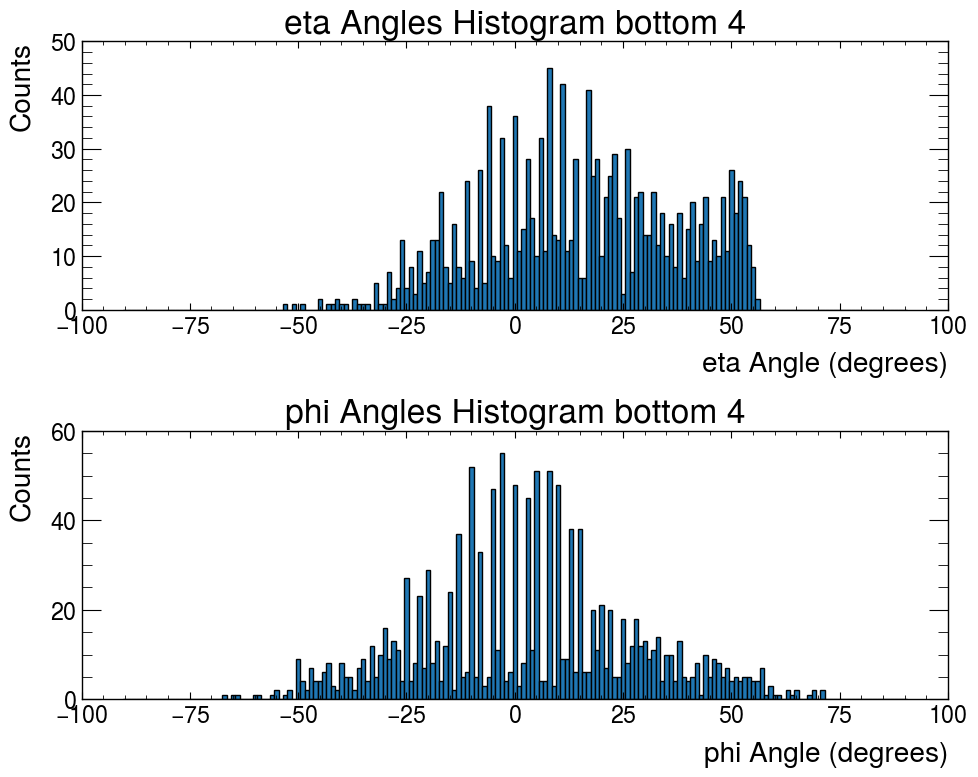

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
aligned = True
lastWasBad = False

bin_size = 1
bin_edges = np.arange(-90.5, 91.5, bin_size)
num_bins = len(bin_edges) - 1

eta_histogram = np.zeros(num_bins)
phi_histogram = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                aligned1 = doRealign(fReader,events[-interval:])
                aligned2 = doRealign(fReader, events[-interval:], -1, -1, 2, 1, 2, 1)
                aligned3 = doRealign(fReader, events[-interval:], -1, -1, 2, 0, 2, 0)
                totally_aligned = aligned1==True and aligned2==True and aligned3==True
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])

                angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

                angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
                angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

                eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
                phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

print(f"Total eta entries: {np.sum(eta_histogram)}")
print(f"Total phi entries: {np.sum(phi_histogram)}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.bar(bin_edges[:-1], eta_histogram, width=bin_size, edgecolor='black', align='edge')
ax1.set_title('eta Angles Histogram bottom 4')
ax1.set_xlabel('eta Angle (degrees)')
ax1.set_ylabel('Counts')

ax2.bar(bin_edges[:-1], phi_histogram, width=bin_size, edgecolor='black', align='edge')
ax2.set_title('phi Angles Histogram bottom 4')
ax2.set_xlabel('phi Angle (degrees)')
ax2.set_ylabel('Counts')


plt.tight_layout()
plt.show()

processing event: 200
Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
Found a new alignment, offsetting by 2 idx is 400 updated TDC 2
processing event: 400
Found a new alignment, offsetting by -2 idx is 600 updated TDC 1
Found a new alignment, offsetting by -2 idx is 600 updated TDC 0
processing event: 600
processing event: 800
processing event: 1000
processing event: 1200
processing event: 1400
processing event: 1600
processing event: 1800
processing event: 2000
processing event: 2200
processing event: 2400
processing event: 2600
processing event: 2800
processing event: 3000
processing event: 3200
processing event: 3400
processing event: 3600
processing event: 3800
processing event: 4000
processing event: 4200
processing event: 4400
processing event: 4600
processing event: 4800
processing event: 5000
processing event: 5200
processing event: 5400
processing event: 5600
processing event: 5800
processing event: 6000
processing event: 6200
processing event: 6400
processing

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:340: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\Peter\AppData\Local\Temp\ipykernel_8844\1875228063.py:344: RuntimeWarning:

invalid value encountered in scalar multiply



processing event: 100200
processing event: 100400
processing event: 100600
processing event: 100800
processing event: 101000
processing event: 101200
processing event: 101400
processing event: 101600
processing event: 101800
processing event: 102000
processing event: 102200
processing event: 102400
processing event: 102600
processing event: 102800
processing event: 103000
processing event: 103200
processing event: 103400
processing event: 103600
processing event: 103800
processing event: 104000
processing event: 104200
processing event: 104400
processing event: 104600
processing event: 104800
processing event: 105000
processing event: 105200
processing event: 105400
processing event: 105600
processing event: 105800
processing event: 106000
processing event: 106200
processing event: 106400
processing event: 106600
processing event: 106800
processing event: 107000
processing event: 107200
processing event: 107400
processing event: 107600
processing event: 107800
processing event: 108000


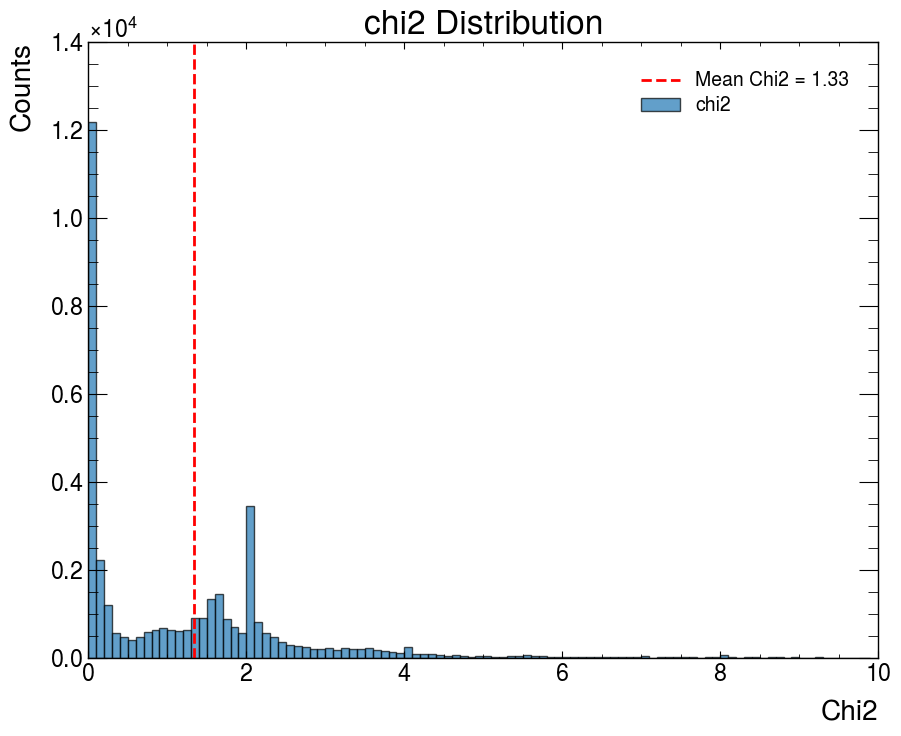

In [ ]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []

bin_size = 0.1
bin_edges = np.arange(0, 10, bin_size)
num_bins = len(bin_edges) - 1

chi2 = np.zeros(num_bins)

while processedEvents < 300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                aligned1 = doRealign(fReader,events[-interval:])
                aligned2 = doRealign(fReader, events[-interval:], -1, -1, 2, 1, 2, 1)
                aligned3 = doRealign(fReader, events[-interval:], -1, -1, 2, 0, 2, 0)
                totally_aligned = aligned1 and aligned2 and aligned
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,4)
                # cross_chamber_3_RPC_events = filter_events_by_RPC(hit_cluster,2,4,5)
                Chi2_values = []
                for ind,event in enumerate(cross_chamber_3_RPC_events):
                    y = reconstruct_timed_Chi2(event,3, exact_length=True, max_length=4)
                    if y:
                        Chi2_values.append(y[4])
                chi2 += np.histogram(Chi2_values, bins=bin_edges)[0]

print(f"Total chi2 entries: {np.sum(chi2)}")

fig, ax = plt.subplots(figsize=(10, 8))

mean_chi2 = np.average(bin_midpoints, weights=chi2)
ax.bar(bin_edges[:-1], chi2, width=bin_size, edgecolor='black', align='edge', alpha=0.7, label='chi2')
ax.axvline(mean_chi2, color='red', linestyle='dashed', linewidth=2, label=f'Mean Chi2 = {mean_chi2:.2f}')
ax.set_title('chi2 Distribution')
ax.set_xlabel('Chi2')
ax.set_ylabel('Counts')
ax.legend()

plt.show()

Good, now we need to align TDC 3 and TDC4

In [524]:
def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = filter_events_by_RPC(dataset,2,5,[RPC])

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[7],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)
    if possible_reconstructions == 0:
        return -1
    else:
        return successful_reconstructions/possible_reconstructions

processing event: 200
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
14
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


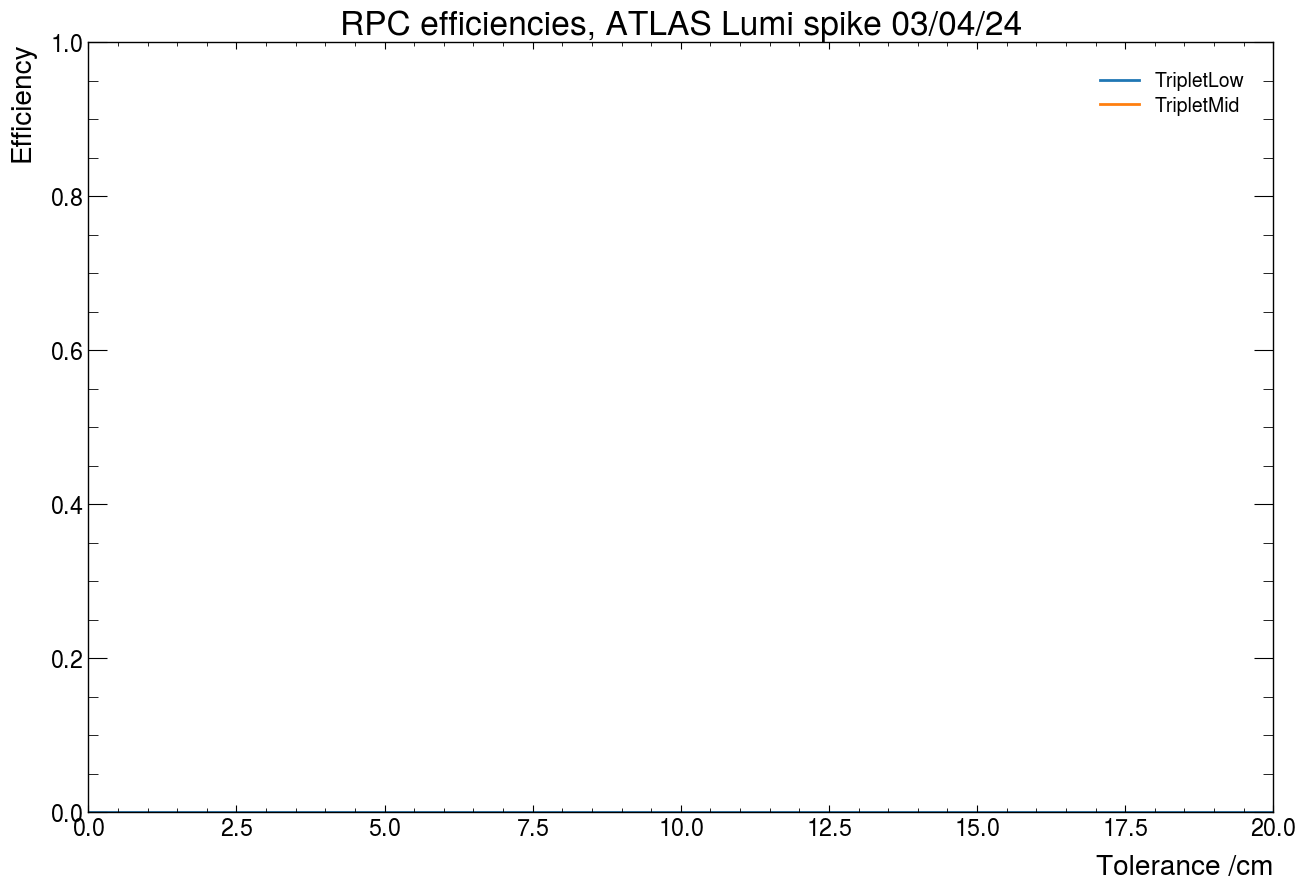

In [548]:
importlib.reload(rawFileReader)

interval = 200
file_path = 'Data/Cosmic.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
efficiencies= []
tolerances = np.linspace(0,20,50)
RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']
hits = []


while processedEvents < 201:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if fReader.hasEvents():
        for event in fReader.getEvents():
            events.append(event)    
            processedEvents += 1
            if processedEvents%interval==0 and processedEvents>0:
                aligned1 = doRealign(fReader,events[-interval:])
                aligned2 = doRealign(fReader, events[-interval:], -1, -1, 2, 1, 2, 1)
                aligned3 = doRealign(fReader, events[-interval:], -1, -1, 2, 0, 2, 0)
                totally_aligned = aligned1 and aligned2 and aligned
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False
                print(f'processing event: {processedEvents}')
                etaHits, phiHits = Unpack_event(events[-interval:], processedEvents)
                coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
                hit_cluster = cluster(coincident_hits)
                hits.append(hit_cluster[0])
                
                for RPC in range(6):
                    if RPC <4:
                        continue

                    efficiencies_RPC = []
                    for tol in tolerances:
                        efficiencies_RPC.append(calc_efficiency_RPC(hit_cluster,RPC,tol))
                    efficiencies.append(efficiencies_RPC)
                plt.figure(figsize=(15,10))

                for ind,data in enumerate(efficiencies):
                    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

                plt.title("RPC efficiencies, ATLAS Lumi spike 03/04/24")

                plt.xlabel('Tolerance /cm')
                plt.ylabel('Efficiency')

                plt.ylim(0,1)

                plt.legend()
                plt.show()



In [545]:
print(hits[0])

[1, 180.0, [[[[[0, 50, 188.8, False]]], [[[0, 1, 193.60000000000002, True], [0, 2, 194.4, True]]]], [[[[1, 50, 187.20000000000002, False]]], [[[1, 2, 195.20000000000002, True]]]], [[[[2, 50, 184.0, False]]], [[[2, 1, 194.4, True], [2, 2, 194.4, True]]]], [[[[3, 44, 185.60000000000002, False], [3, 45, 182.4, False]]], [[[3, 7, 190.4, True]]]], [[[[4, 0, 468.8, False]], [[4, 40, 180.0, False]]], [[[4, 12, 189.60000000000002, True]]]], [[[[5, 0, 468.0, False]]], []]]]


In [494]:
print(len(events))

8393


In [505]:
offsetTest = []
Efficiency = []


for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    possible_reconstructions = 0
    successful_reconstructions = 0
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for i in range(5):
                for word in events[oneIdx].tdcEvents[i].words:
                    rpc, thisHit = tdcChanToRPCHit(word,i, idx)
                    if thisHit.eta:
                        etaHits[thisHit.rpc].append(thisHit)
                    else:
                        phiHits[thisHit.rpc].append(thisHit)
            coincident_hits = FindCoincidentHits(etaHits,phiHits,15)
            hit_cluster = cluster(coincident_hits)
            Bottom4RPC = filter_events_by_RPC(hit_cluster,2,4,[4, 5])
            for ind,evt in enumerate(Bottom4RPC):
                y = reconstruct_timed_Chi2(evt,3, exact_length=True, max_length=4)
                if y:
                    possible_reconstructions += 1
                    extrapolated_location = does_muon_hit_RPC(y[0], y[1], 4)
                    if extrapolated_location:
                        test_coord = extract_coords_timed_Chi2(hit_cluster[0],3)
                        check = does_RPC_detect_muon(extrapolated_location,test_coord[4],10)
                        if check:
                            successful_reconstructions += 1
    Efficiency.append(successful_reconstructions/possible_reconstructions)
        
                    
            # if hit_cluster[0][2][4][0] != [] and hit_cluster[0][2][4][1] != []:
            #     break
            # angles_eta, angles_phi, times_delta, z_delta, chi2_values = extract_angles_phi_eta_timed_DZ_modified(cross_chamber_3_RPC_events, max_length=4, exact_length=True)

            # angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
            # angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]

            # eta_histogram += np.histogram(angles_eta_degrees, bins=bin_edges)[0]
            # phi_histogram += np.histogram(angles_phi_degrees, bins=bin_edges)[0]

                    
            
               
            # etOff = testAlign(etaHits[1],etaHits[2])
            # phOff = testAlign(phiHits[0],phiHits[1])
            # Metric = etOff*etOff+phOff*phOff
            # # print(Metric)
            # if etOff>=0 and phOff>=0:
            #     offsetTest[-1].append(math.sqrt(Metric))
            # else:
            #     offsetTest[-1].append(-1)
            # #if etOff>0:
            # #    offsetTest[-1].append(etOff)   

0
1
2
3


In [506]:
print(Efficiency)

[0.0, 0.0, 0.0, 0.0]


In [ ]:
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc0 tdc 1 aligned')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()

In [82]:
def find_tdc_alignment_metric(tdc0, tdc1):
    i, j, k, l = None, None, None, None
    if tdc0 == 0:
        if tdc1 == 1:
            i, j, k, l = 1, 2, 0, 1
        if tdc1 == 2:
            i, j, k, l = 3, 0, 3, 0
    if tdc0 == 1:
        if tdc1 == 2:
            i, j, k, l = 3,2,3,2
        
    return i, j, k, l
        
    

In [ ]:
def tdcChanToRPCHit(word, tdc, event_num):
    tdcChannel = (word >> 24) & 0x7f
    tdcHitTime = word & 0xfffff
    eta = False
    rpcChan = -1
    if tdc == 0:
        if tdcChannel < 32:
            rpcChan = tdcChannel
            eta = True
            rpc = 0
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 0
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 1
    elif tdc == 1:
        if tdcChannel < 64:
            rpcChan = tdcChannel
            eta = False
            rpc = 1
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 64
            eta = True
            rpc = 2
        else:
            rpcChan = tdcChannel - 96
            eta = False
            rpc = 2
    elif tdc == 2:
        if tdcChannel < 32:
            rpcChan = tdcChannel + 32
            eta = False
            rpc = 2
        elif tdcChannel < 64:
            rpcChan = tdcChannel - 32
            eta = True
            rpc = 3
        elif tdcChannel < 128:
            rpcChan = tdcChannel - 64
            eta = False
            rpc = 3
    elif tdc == 3:
        if tdcChannel < 32:
            rpcChan = tdcChannel
            eta = True
            rpc = 4
        elif tdcChannel < 96:
            rpcChan = tdcChannel - 32
            eta = False
            rpc = 4
        else:
            rpcChan = tdcChannel - 96
            eta = True
            rpc = 5
    elif tdc == 4:
        rpcChan = tdcChannel
        eta = False
        rpc = 5
    return rpc, rpcHit(rpcChan, tdcHitTime * 0.8, eta, event_num, rpc)

In [86]:
importlib.reload(rawFileReader)
file_path = 'Data/Beam.raw'
fReader = rawFileReader.fileReader(file_path)
processedEvents = 0
events = []
lastWasBad = False
values = [0, 1, 2]
# aligned = True
alignevt = [[[], [], [], [], []] for _ in range(5)]
while processedEvents<300000:
    if not fReader.readBlock():
        print("Bad Block Read")
        break
    if(fReader.hasEvents()):
        for event in fReader.getEvents():
            events.append(event)
            processedEvents = processedEvents+1
            aligned_check = []
            if processedEvents%200==0 and processedEvents>0:
                for i in values:
                    for j in values:
                        if i < j:
                            x, y, l, m = find_tdc_alignment_metric(i, j)
                            aligned, update = doRealign(fReader, events[-200:], x, y, l, m, i, j)
                            aligned_check.append(aligned)
                            if update != -1:
                                if update ==1:
                                    alignevt[i][j].append(processedEvents)
                                else:
                                    alignevt[j][i].append(processedEvents)   
                totally_aligned = result = reduce(lambda x, y: x and y, aligned_check)
                if lastWasBad and not totally_aligned:
                    print("Two bad aligns in a row, processedEvents is",processedEvents)
                elif not totally_aligned:
                    lastWasBad = True
                else:
                    lastWasBad = False                  

Found a new alignment, offsetting by -2 idx is 200 updated TDC 2
Found a new alignment, offsetting by -2 idx is 200 updated TDC 2
Found a new alignment, offsetting by 2 idx is 400 updated TDC 0
Found a new alignment, offsetting by 2 idx is 400 updated TDC 1
Found a new alignment, offsetting by -1 idx is 9000 updated TDC 1
Found a new alignment, offsetting by -1 idx is 9000 updated TDC 2
Found a new alignment, offsetting by -1 idx is 32200 updated TDC 1
Found a new alignment, offsetting by -1 idx is 32200 updated TDC 2
Found a new alignment, offsetting by -1 idx is 63200 updated TDC 1
Found a new alignment, offsetting by -1 idx is 63200 updated TDC 2
Found a new alignment, offsetting by -1 idx is 79000 updated TDC 1
Found a new alignment, offsetting by -1 idx is 79000 updated TDC 2
Found a new alignment, offsetting by -1 idx is 122200 updated TDC 1
Found a new alignment, offsetting by -1 idx is 122200 updated TDC 2
Found a new alignment, offsetting by 1 idx is 128000 updated TDC 0
Found

<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_33804\2231580496.py:79: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')


0
1
2
3


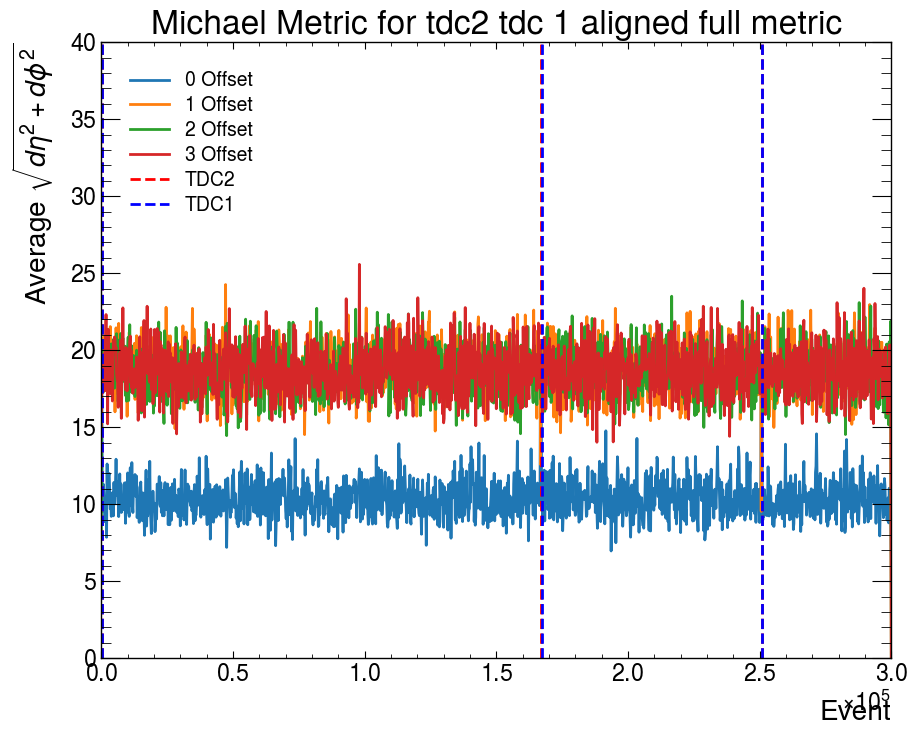

In [87]:
offsetTest = []
for offSet in range(4):
    offsetTest.append([])
    print(offSet)
    for idx, event in enumerate(events):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        if (idx+offSet)<len(events):
            if offSet>25:
                oneIdx = idx+offSet-25
                twoIdx = idx
            else:
                oneIdx = idx
                twoIdx = idx+offSet
            for word in events[oneIdx].tdcEvents[2].words:
                rpc, thisHit = tdcChanToRPCHit(word,2, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
            for word in events[twoIdx].tdcEvents[1].words:
                rpc, thisHit = tdcChanToRPCHit(word,1, idx)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)        
            etOff = testAlign(etaHits[3],etaHits[2])
            phOff = testAlign(phiHits[3],phiHits[2])
            Metric = etOff*etOff+phOff*phOff
            # print(Metric)
            if etOff>=0 and phOff>=0:
                offsetTest[-1].append(math.sqrt(Metric))
            else:
                offsetTest[-1].append(-1)
            #if etOff>0:
            #    offsetTest[-1].append(etOff)   
binsx = [x*200 for x in range(3000)]
noffs = 4
offsets = [[0 for xbin in binsx] for offset in range(noffs)]
offsetOne = [0 for xbin in binsx]
for testOff in range(noffs):
    xbin=0
    counts=0
    for idx, offset in enumerate(offsetTest[testOff]):
        if offset>-0.5:
            offsets[testOff][xbin]=offsets[testOff][xbin]+offset
            counts = counts+1
        if idx%200==0 and idx>0:
            if counts>0:
                offsets[testOff][xbin]=offsets[testOff][xbin]/counts
            xbin=xbin+1
            counts=0
    if counts>0:
        offsets[testOff][xbin]=offsets[testOff][xbin]/counts

fig, ax = plt.subplots(figsize=(10, 8))
for idx, offsethist in enumerate(offsets):
    ax.plot(binsx,offsethist,label=str(idx)+' Offset')
    
plotted_tdc2 = False
plotted_tdc1 = False
for x in alignevt[2][1]:
    if not plotted_tdc2:
        ax.axvline(x=x, color='r', linestyle='--', label='TDC2')
        plotted_tdc2 = True
    else:
        ax.axvline(x=x, color='r', linestyle='--')
for x in alignevt[1][2]:
    if not plotted_tdc1:
        ax.axvline(x=x, color='b', linestyle='--', label='TDC1')
        plotted_tdc1 = True
    else:
        ax.axvline(x=x, color='b', linestyle='--')

ax.set_xlim(0,300000)
ax.set_ylim(0,40)
ax.legend()
ax.set_title('Michael Metric for tdc2 tdc 1 aligned full metric')
ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
ax.set_xlabel('Event')
plt.show()